In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def visualize_judge_comparison(df, output_path=None):
    """
    Create enhanced visualizations comparing original and enhanced SQL judge performance
    with fixed complexity classes and NaN handling
    """
    # Define complexity classes and their order
    _COMPLEXITY_CLASSES = [
        "basic SQL",
        "aggregation",
        "single join",
        "window functions",
        "multiple_joins",
        "subqueries",
        "set operations",
    ]
    
    # First, let's flatten the nested enhanced_judgment dictionary
    flat_df = df.copy()
    
    # Extract nested fields if they're not already extracted
    if 'enhanced_judgment.technically_equivalent' not in flat_df.columns:
        flat_df['enhanced_judgment.technically_equivalent'] = flat_df['enhanced_judgment'].apply(
            lambda x: x.get('technically_equivalent', False) if isinstance(x, dict) else False
        )
        flat_df['enhanced_judgment.fulfills_intent'] = flat_df['enhanced_judgment'].apply(
            lambda x: x.get('fulfills_intent', False) if isinstance(x, dict) else False
        )
        flat_df['enhanced_judgment.superiority'] = flat_df['enhanced_judgment'].apply(
            lambda x: x.get('superiority', 'equal') if isinstance(x, dict) else 'equal'
        )
        flat_df['enhanced_judgment.overall_assessment'] = flat_df['enhanced_judgment'].apply(
            lambda x: x.get('overall_assessment', 'incorrect') if isinstance(x, dict) else 'incorrect'
        )
    
    # Set the style for better aesthetics
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Define column names
    original_col = 'llm_equivalent'  # Original judge result
    enhanced_cols = ['enhanced_judgment.technically_equivalent', 
                    'enhanced_judgment.fulfills_intent']
    labels = ['Original Judge', 'Enhanced (Technical)', 'Enhanced (Intent)']
    
    # 1. SQL COMPLEXITY BAR CHART WITH PERCENTAGES
    # Fill NaN values and convert to string
    flat_df['sql_complexity'] = flat_df['sql_complexity'].fillna('Unknown').astype(str)
    
    # Group by SQL complexity and calculate percentages
    cols_to_plot = [original_col] + enhanced_cols
    complexity_accuracy = flat_df.groupby('sql_complexity')[cols_to_plot].mean().multiply(100).reset_index()
    
    # Ensure all complexity names are in our list, add any that aren't at the end
    all_complexities = list(_COMPLEXITY_CLASSES)
    for complexity in complexity_accuracy['sql_complexity'].unique():
        if complexity not in all_complexities and complexity != 'Unknown':
            all_complexities.append(complexity)
    if 'Unknown' in complexity_accuracy['sql_complexity'].unique():
        all_complexities.append('Unknown')
        
    # Filter to only include complexities that exist in the data
    valid_order = [x for x in all_complexities if x in complexity_accuracy['sql_complexity'].values]
    
    complexity_accuracy['sql_complexity'] = pd.Categorical(
        complexity_accuracy['sql_complexity'], categories=valid_order, ordered=True)
    complexity_accuracy = complexity_accuracy.sort_values('sql_complexity')
    
    # Create the figure with horizontal bars
    plt.figure(figsize=(14, 10))
    
    # Plot horizontal bars for better label display
    colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red
    
    # Prepare data for horizontal bar chart
    complexity_names = complexity_accuracy['sql_complexity'].tolist()
    x = np.arange(len(complexity_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot horizontal bars
    rects1 = ax.barh(x - width, complexity_accuracy[original_col], width, label=labels[0], color=colors[0])
    rects2 = ax.barh(x, complexity_accuracy[enhanced_cols[0]], width, label=labels[1], color=colors[1])
    rects3 = ax.barh(x + width, complexity_accuracy[enhanced_cols[1]], width, label=labels[2], color=colors[2])
    
    # Add percentage labels on each bar
    def add_labels(rects):
        for rect in rects:
            width = rect.get_width()
            ax.annotate(f'{width:.1f}%',
                        xy=(width, rect.get_y() + rect.get_height()/2),
                        xytext=(4, 0),  # 3 points horizontal offset
                        textcoords="offset points",
                        ha='left', va='center',
                        fontsize=9, fontweight='bold')
    
    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)
    
    # Enhance the plot
    ax.set_title('SQL Judge Performance Comparison by Complexity', fontsize=16, fontweight='bold')
    ax.set_xlabel('Accuracy Rate (%)', fontsize=13, fontweight='bold')
    ax.set_yticks(x)
    
    # Safe label formatting
    formatted_labels = []
    for name in complexity_names:
        if name == 'Unknown':
            formatted_labels.append('Unknown')
        else:
            formatted_labels.append(str(name).replace('_', ' ').title())
    
    ax.set_yticklabels(formatted_labels)
    ax.set_ylabel('SQL Complexity', fontsize=13, fontweight='bold')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=True)
    
    # Add grid lines
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Set x-axis limit
    ax.set_xlim(0, 105)  # Give some room for the percentage labels
    
    # Add overall statistics
    overall_orig = flat_df[original_col].mean() * 100
    overall_tech = flat_df[enhanced_cols[0]].mean() * 100
    overall_intent = flat_df[enhanced_cols[1]].mean() * 100
    
    stats_text = (
        f"Overall Accuracy:\n"
        f"Original Judge: {overall_orig:.1f}%\n"
        f"Enhanced (Technical): {overall_tech:.1f}% ({overall_tech-overall_orig:+.1f}%)\n"
        f"Enhanced (Intent): {overall_intent:.1f}% ({overall_intent-overall_orig:+.1f}%)"
    )
    
    plt.annotate(stats_text, xy=(0.02, 0.02), xycoords='figure fraction', 
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                 fontsize=10)
    
    plt.tight_layout()
    
    # Save if path provided
    if output_path:
        plt.savefig(f"{output_path}_comparison.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 2. SUPERIORITY PIE CHART
    plt.figure(figsize=(10, 8))
    
    # Get superiority counts
    sup_counts = flat_df['enhanced_judgment.superiority'].value_counts()
    
    # Create pie chart with better colors
    colors = ['#3498db', '#2ecc71', '#f1c40f']  # Blue, Green, Yellow
    
    # Create clean labels with percentages
    total = len(flat_df)
    labels = []
    for category in sup_counts.index:
        count = sup_counts[category]
        percent = count / total * 100
        # Convert "reference" to "Reference", etc.
        category_name = str(category).replace('_', ' ').capitalize() 
        labels.append(f"{category_name}: {count} ({percent:.1f}%)")
    
    plt.pie(
        sup_counts, 
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05] * len(sup_counts),
        shadow=True,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    
    plt.title('Query Superiority Assessment', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(f"{output_path}_superiority.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # 3. OVERALL ASSESSMENT PIE CHART
    plt.figure(figsize=(10, 8))
    
    # Get assessment counts
    assessment_counts = flat_df['enhanced_judgment.overall_assessment'].value_counts()
    
    # Create clean labels with percentages
    total = len(flat_df)
    labels = []
    for category in assessment_counts.index:
        count = assessment_counts[category]
        percent = count / total * 100
        # Convert "differently_correct" to "Differently Correct", etc.
        category_name = str(category).replace('_', ' ').title()
        labels.append(f"{category_name}: {count} ({percent:.1f}%)")
    
    # Create pie chart with different colors
    colors = ['#e74c3c', '#3498db', '#f1c40f']  # Red, Blue, Yellow
    plt.pie(
        assessment_counts, 
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05] * len(assessment_counts),
        shadow=True,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    
    plt.title('Overall Assessment', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(f"{output_path}_assessment.png", dpi=300, bbox_inches='tight')
    
    plt.show()

<Figure size 1400x1000 with 0 Axes>

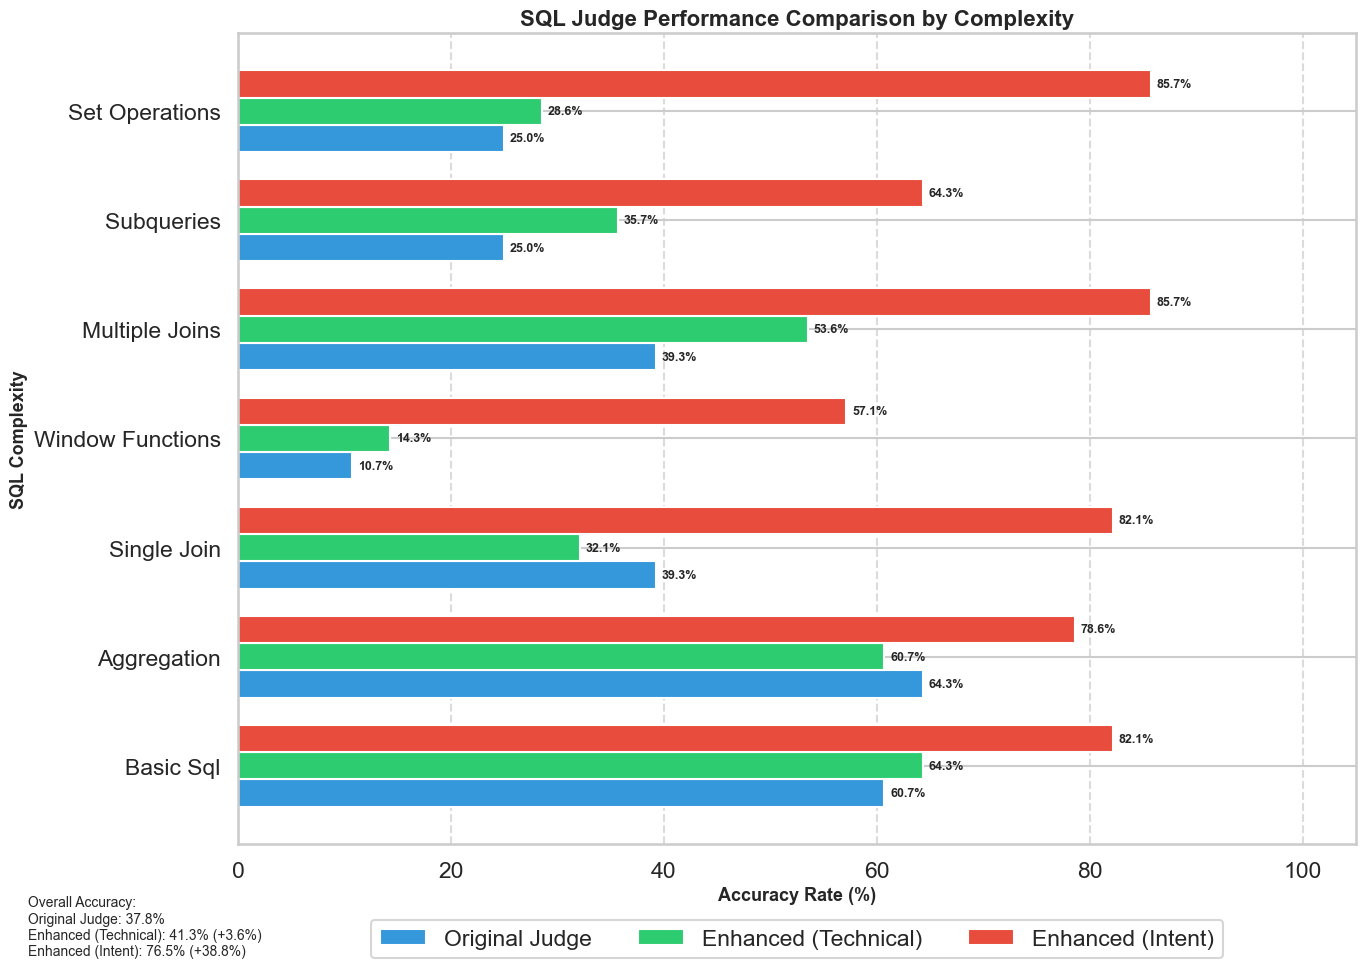

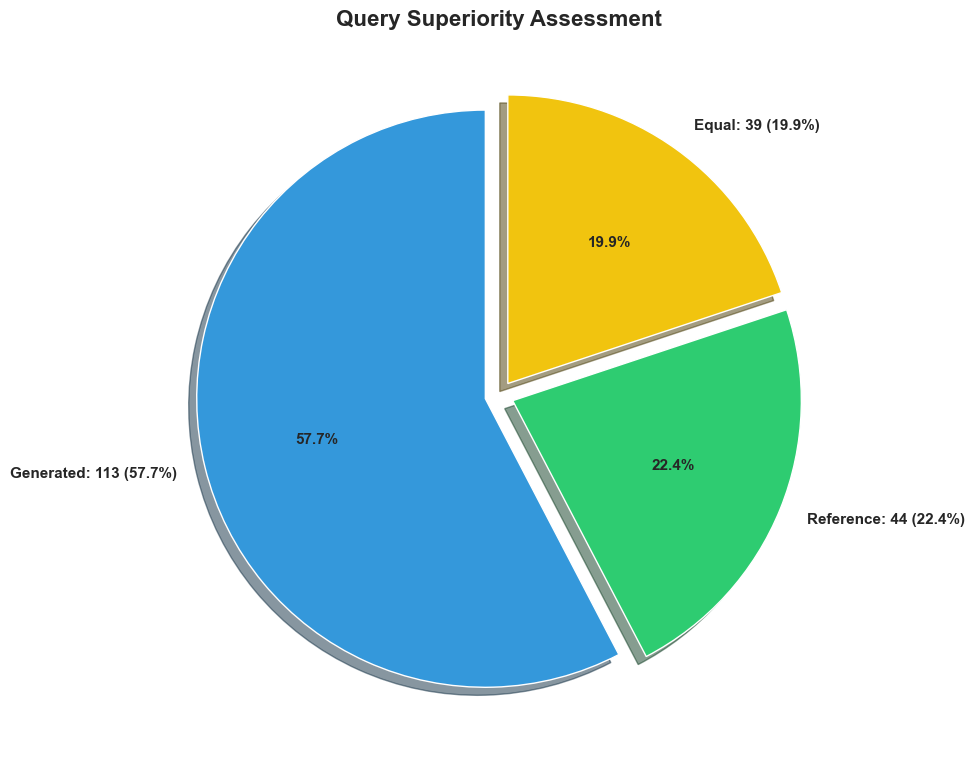

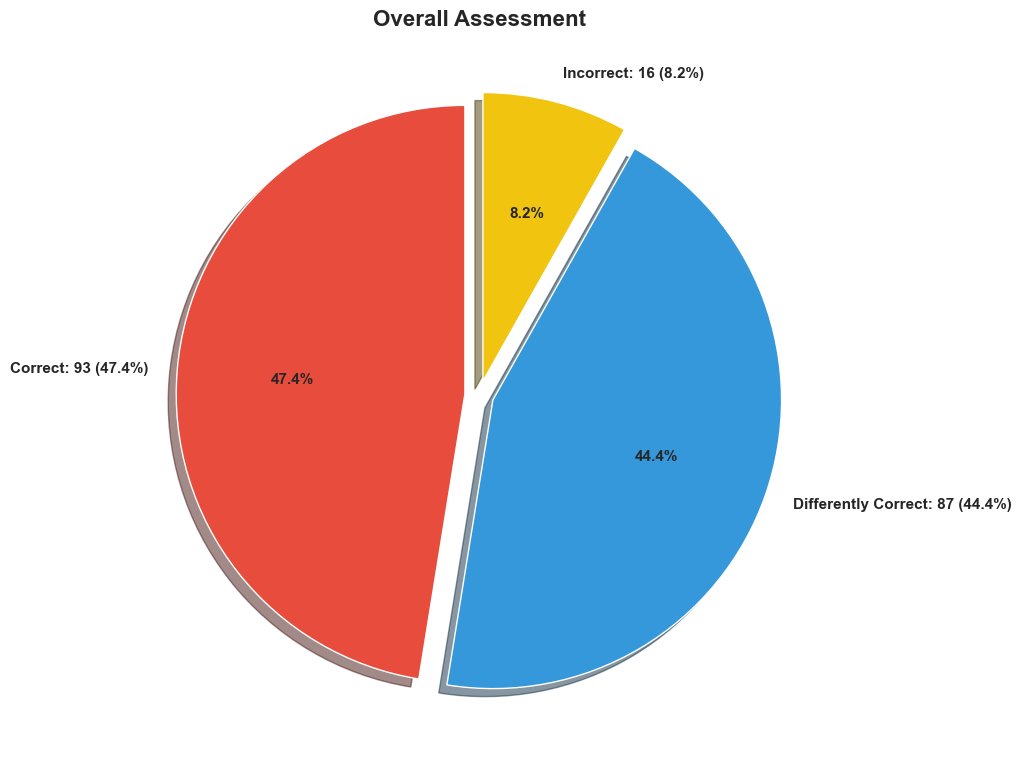

In [43]:
import pandas as pd

# df = pd.read_json("better_benchmarks/deepseek-r1-14b.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/gemma3-12b.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/gpt-4.1.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/o3-mini.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/qwen3-14b.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/sqlcoder-latest.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/qwen2.5-latest.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/o3.jsonl", lines=True)
# df = pd.read_json("better_benchmarks/o4-mini.jsonl", lines=True)
df = pd.read_json("better_benchmarks/qwen2.5-14b.jsonl", lines=True)
df = pd.read_json("better_benchmarks/phi4-14b.jsonl", lines=True)
df = pd.read_json("better_benchmarks/gpt-4.1-nano.jsonl", lines=True)

visualize_judge_comparison(df)

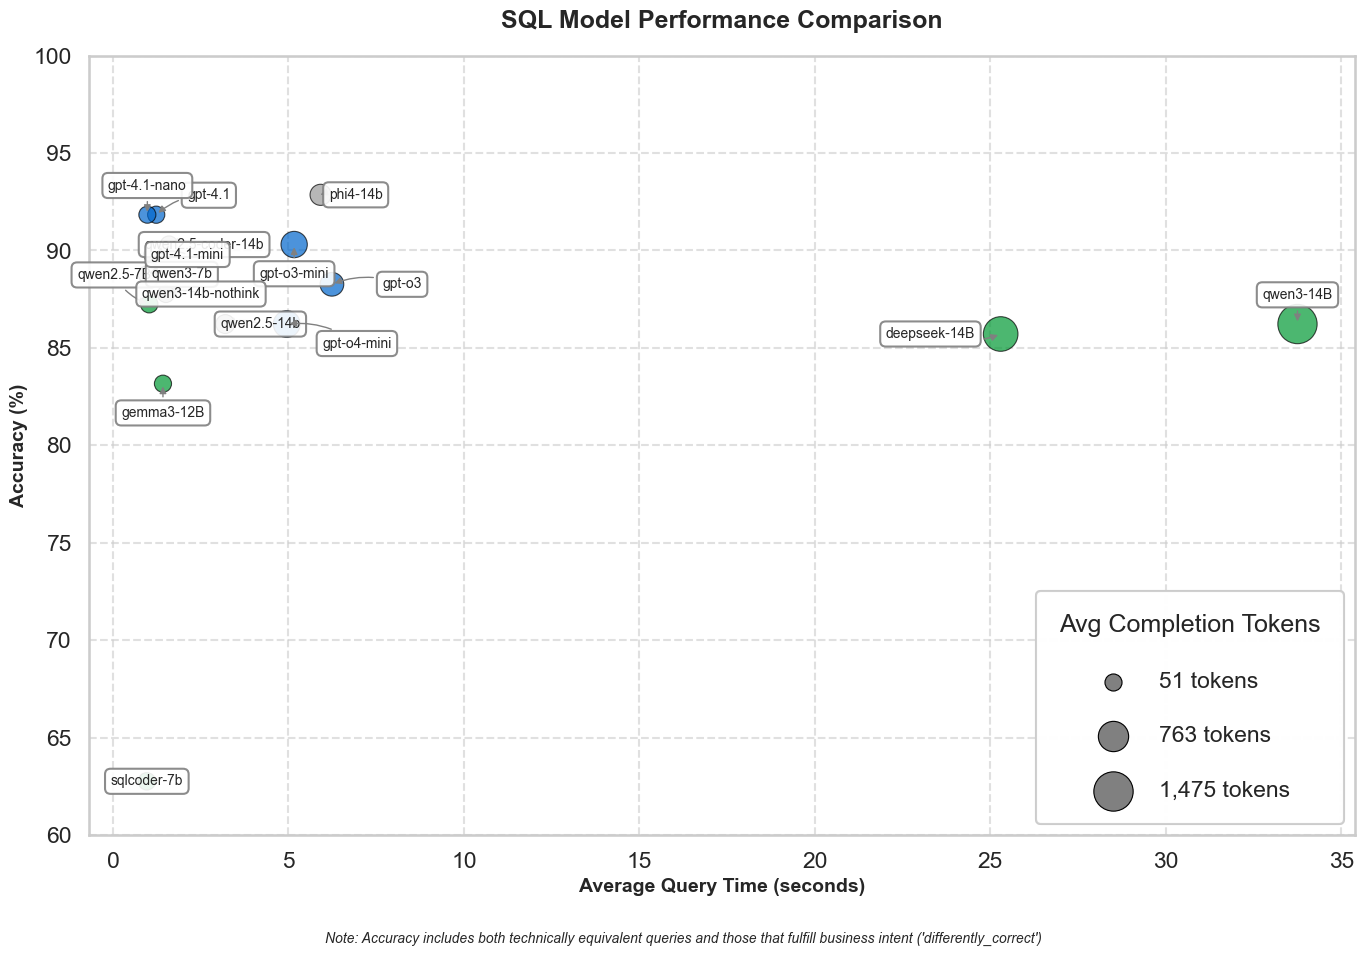

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
from matplotlib.lines import Line2D

# Set style for a cleaner look
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ------------------------------------------------------------
# 1) Load and process all model data
# ------------------------------------------------------------
def load_model_data(file_path):
    """Load and process a single model's data file"""
    model_name = os.path.basename(file_path).replace('.jsonl', '')
    
    # Load data
    df = pd.read_json(file_path, lines=True)
    
    # Extract nested fields if they're not already extracted
    if 'enhanced_judgment.overall_assessment' not in df.columns:
        df['enhanced_judgment.overall_assessment'] = df['enhanced_judgment'].apply(
            lambda x: x.get('overall_assessment', 'incorrect') if isinstance(x, dict) else 'incorrect'
        )
    
    # Calculate accuracy (both "correct" and "differently_correct" count as correct)
    correct_count = sum(df['enhanced_judgment.overall_assessment'].isin(['correct', 'differently_correct']))
    accuracy = (correct_count / len(df)) * 100
    
    # Calculate average time
    avg_time = df['latency_sec'].mean()
    
    # Calculate average tokens
    avg_tokens = df['tokens_completion'].mean() if 'tokens_completion' in df.columns else 0
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'avg_time': avg_time,
        'avg_tokens': avg_tokens,
        'total_examples': len(df)
    }

# Find all JSONL files in the better_benchmarks directory
file_paths = glob.glob('better_benchmarks/*.jsonl')

# Process all files
model_data = [load_model_data(file_path) for file_path in file_paths]

# Create a DataFrame from the results
acc_df = pd.DataFrame(model_data)

# ------------------------------------------------------------
# 2) Define model naming and categories
# ------------------------------------------------------------
# Model display names
model_name_map = {
    'deepseek-r1-14b': 'deepseek-14B',
    'gemma3-12b': 'gemma3-12B',
    'gpt-4.1-nano': 'gpt-4.1-nano',
    'gpt-4.1': 'gpt-4.1',
    'o3-mini': 'gpt-o3-mini',
    'o3': 'gpt-o3',
    'o4-mini': 'gpt-o4-mini',
    'qwen3-14b': 'qwen3-14B',
    'sqlcoder-latest': 'sqlcoder-7b',
    'qwen2.5-latest': 'qwen2.5-7B'
}

# Define the source categories
model_categories = {
    'Open Source Models': ['deepseek-r1-14b', 'gemma3-12b', 'qwen3-14b', 'sqlcoder-latest', 'qwen2.5-latest'],
    'Closed Source Models': ['o3-mini', 'o3', 'o4-mini', 'gpt-4.1', 'gpt-4.1-nano']
}

# Define colors for source categories
category_colors = {
    'Open Source Models': '#009933',  # Green
    'Closed Source Models': '#0066CC'  # Blue
}

# Assign category
acc_df['category'] = 'Unknown'
for model in acc_df['model']:
    # Assign category
    for category, models in model_categories.items():
        if model in models:
            acc_df.loc[acc_df['model'] == model, 'category'] = category

# Assign colors and display names
acc_df['color'] = acc_df['category'].map(category_colors).fillna('#999999')  # Gray for unknown
acc_df['model_display'] = acc_df['model'].map(model_name_map).fillna(acc_df['model'])

# ------------------------------------------------------------
# 3) Scale token counts for bubble sizes
# ------------------------------------------------------------
S_MIN, S_MAX = 150, 800
def scale_sizes(series, s_min=S_MIN, s_max=S_MAX):
    if series.max() == series.min():
        return np.full_like(series, (s_min + s_max) / 2)
    return np.interp(series, (series.min(), series.max()), (s_min, s_max))

sizes = scale_sizes(acc_df["avg_tokens"])

# ------------------------------------------------------------
# 4) Create the plot
# ------------------------------------------------------------
plt.figure(figsize=(14, 10))
plt.grid(linestyle="--", alpha=0.6, zorder=0)

# Create the scatter plot with custom colors and reduced border thickness
scatter = plt.scatter(
    acc_df["avg_time"],
    acc_df["accuracy"],
    s=sizes,
    c=acc_df["color"],
    alpha=0.7,
    edgecolors='black',
    linewidth=0.8,  # Thinner border
    zorder=10
)

# ------------------------------------------------------------
# 5) Create manual label placement to avoid overlapping
# ------------------------------------------------------------
# Create a dictionary mapping model to its offset values
# Models that are clustered need more spread-out offsets
label_offsets = {
    # Format: 'model_name': (x_offset, y_offset)
    'gpt-4.1': (1.5, 1.0),           # Move up and right
    'gpt-4.1-nano': (0, 1.5),        # Move up
    'o3-mini': (0, -1.5),            # Move down
    'o3': (2.0, 0),                  # Move right
    'o4-mini': (2.0, -1.0),          # Move right and down
    'qwen2.5-latest': (-1.0, 1.5),   # Move up and left
    'qwen3-14b': (0, 1.5),           # Move up
    'gemma3-12b': (0, -1.5),         # Move down
    'deepseek-r1-14b': (-2.0, 0),    # Move left
    'sqlcoder-latest': (0, 0)        # Default position
}

# Add lines connecting points to labels and create the labels
for _, row in acc_df.iterrows():
    model_id = row['model']
    x_offset, y_offset = label_offsets.get(model_id, (1.0, 0))  # Default offset if not specified
    
    # Draw an arrow connecting the point to the label
    plt.annotate(
        row.model_display, 
        xy=(row.avg_time, row.accuracy),  # Point position
        xytext=(row.avg_time + x_offset, row.accuracy + y_offset),  # Label position with offset
        fontsize=10,
        ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9),
        arrowprops=dict(arrowstyle="-|>", color="gray", lw=1.0,
                        connectionstyle="arc3,rad=0.2" if abs(x_offset) > 0 else "arc3,rad=0"),
        zorder=20
    )

# ------------------------------------------------------------
# 6) Add legends and labels
# ------------------------------------------------------------
# Add source category color legend
category_handles = []
for category, color in category_colors.items():
    category_handles.append(Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, markeredgecolor='black',
                            markersize=12, linewidth=0.8, label=category))

# Create the legend
plt.legend(handles=category_handles, loc="upper right", 
           frameon=True, framealpha=0.9, title="Model Types")

# Add bubble size legend
token_vals = [
    int(acc_df["avg_tokens"].min()),
    int((acc_df["avg_tokens"].max() + acc_df["avg_tokens"].min()) / 2),
    int(acc_df["avg_tokens"].max())
]
size_vals = scale_sizes(pd.Series(token_vals))
handles = [plt.scatter([], [], s=s, color="gray", edgecolor="black", linewidth=0.8) for s in size_vals]
labels = [f"{t:,} tokens" for t in token_vals]

size_legend = plt.legend(handles, labels,
                         title="Avg Completion Tokens",
                         scatterpoints=1,
                         loc="lower right",
                         labelspacing=1.5,
                         borderpad=1.0,
                         handletextpad=1.0,
                         frameon=True, framealpha=0.9)
plt.gca().add_artist(size_legend)

# Add labels and title
plt.xlabel("Average Query Time (seconds)", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=14, fontweight='bold')
plt.title("SQL Model Performance Comparison", fontsize=18, fontweight='bold', pad=20)

# Set y-axis to start from a reasonable minimum value
min_acc = max(60, acc_df["accuracy"].min() - 5)
plt.ylim(min_acc, 100)

# Add a note about accuracy definition
plt.figtext(0.5, 0.01, 
            "Note: Accuracy includes both technically equivalent queries and those that fulfill business intent ('differently_correct')",
            ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('sql_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

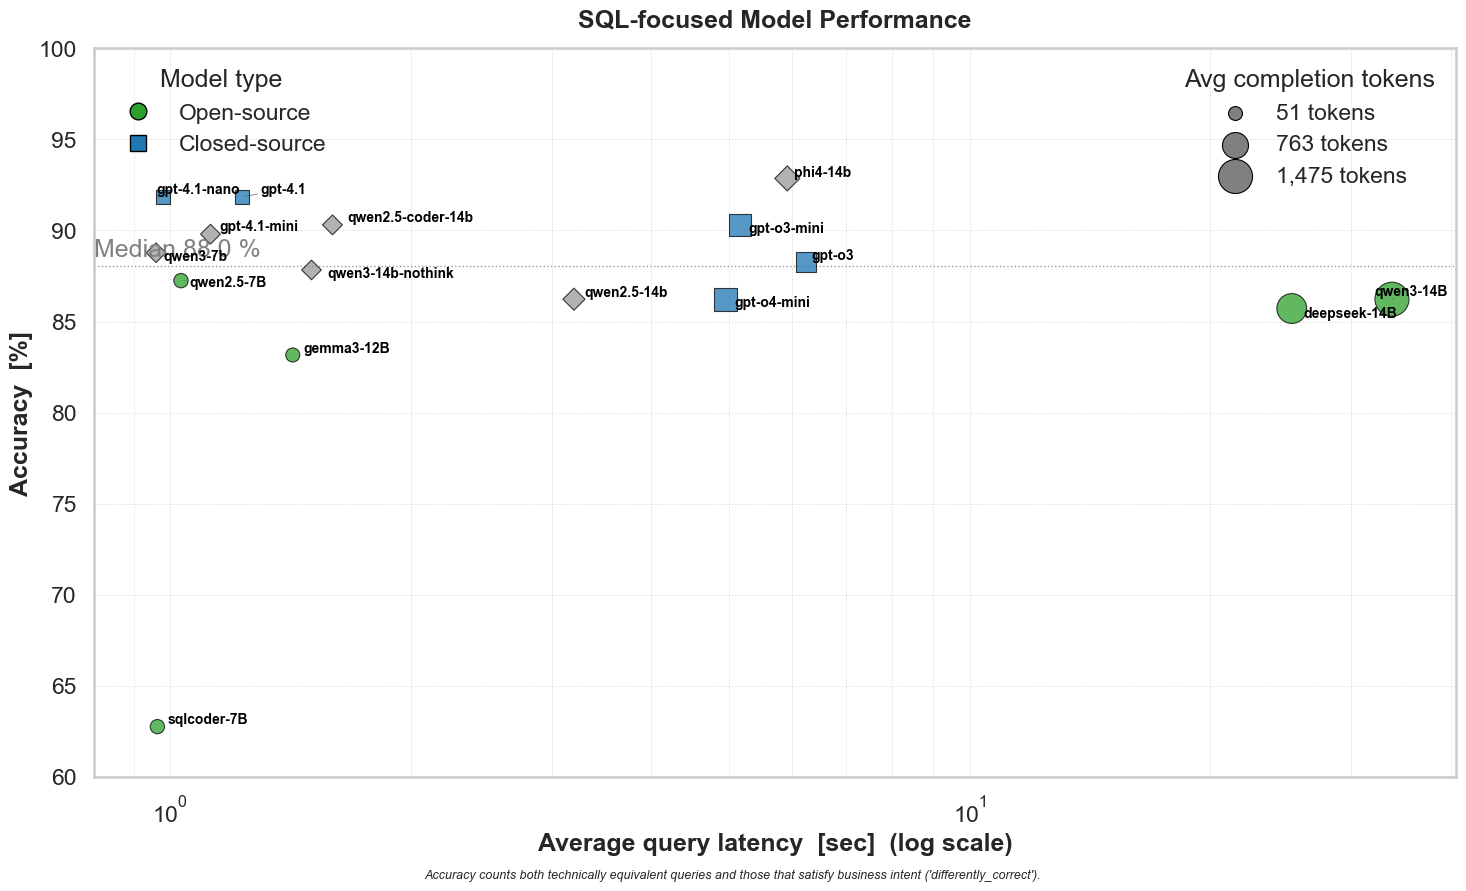

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from adjustText import adjust_text
from matplotlib.lines import Line2D
import glob, os

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ------------------------------------------------------------------
# 1) Load ↦ same as before (unchanged, compressed for brevity)
# ------------------------------------------------------------------
def load_model_data(path):
    name = os.path.basename(path).replace(".jsonl", "")
    df   = pd.read_json(path, lines=True)

    if 'enhanced_judgment.overall_assessment' not in df.columns:
        df['enhanced_judgment.overall_assessment'] = df['enhanced_judgment'].apply(
            lambda x: x.get("overall_assessment", "incorrect") if isinstance(x, dict) else "incorrect"
        )

    correct = df['enhanced_judgment.overall_assessment'].isin(['correct', 'differently_correct']).sum()
    return {
        "model"        : name,
        "accuracy"     : correct / len(df) * 100,
        "avg_time"     : df['latency_sec'].mean(),
        "avg_tokens"   : df.get('tokens_completion', pd.Series([0]*len(df))).mean(),
        "n_examples"   : len(df)
    }

paths     = glob.glob("better_benchmarks/*.jsonl")
acc_df    = pd.DataFrame([load_model_data(p) for p in paths])

# ------------------------------------------------------------------
# 2) Display names, categories, colours, markers
# ------------------------------------------------------------------
name_map = {
  'deepseek-r1-14b':'deepseek-14B', 'gemma3-12b':'gemma3-12B',
  'gpt-4.1-nano':'gpt-4.1-nano', 'gpt-4.1':'gpt-4.1',
  'o3-mini':'gpt-o3-mini', 'o3':'gpt-o3', 'o4-mini':'gpt-o4-mini',
  'qwen3-14b':'qwen3-14B', 'sqlcoder-latest':'sqlcoder-7B',
  'qwen2.5-latest':'qwen2.5-7B'
}

categories = {
    'Open-source': ['deepseek-r1-14b','gemma3-12b','qwen3-14b','sqlcoder-latest','qwen2.5-latest'],
    'Closed-source': ['o3-mini','o3','o4-mini','gpt-4.1','gpt-4.1-nano']
}
cat_pal   = {'Open-source':'#2ca02c', 'Closed-source':'#1f77b4'}
cat_mark  = {'Open-source':'o',      'Closed-source':'s'}

acc_df['category']     = acc_df['model'].apply(
    lambda m: next((k for k,v in categories.items() if m in v),'Other'))
acc_df['colour']       = acc_df['category'].map(cat_pal).fillna('#999999')
acc_df['marker']       = acc_df['category'].map(cat_mark).fillna('D')
acc_df['model_disp']   = acc_df['model'].map(name_map).fillna(acc_df['model'])

# ------------------------------------------------------------------
# 3) Bubble sizes (slightly narrower range)
# ------------------------------------------------------------------
def scale(series, lo=100, hi=600):
    return np.interp(series, (series.min(), series.max()), (lo, hi))
acc_df['size'] = scale(acc_df['avg_tokens'])

# ------------------------------------------------------------------
# 4) Plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 9))

# log-scale on latency
ax.set_xscale('log')
ax.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.6)

# Scatter: draw one category at a time so we can use different markers
for cat in acc_df['category'].unique():
    df_cat = acc_df[acc_df['category']==cat]
    ax.scatter(df_cat['avg_time'], df_cat['accuracy'],
               s=df_cat['size'],
               c=df_cat['colour'],
               marker=df_cat['marker'].iloc[0],
               edgecolor='black', linewidth=0.8, alpha=0.75, label=cat, zorder=3)

# ------------------------------------------------------------------
# 5) Automatic text labels
# ------------------------------------------------------------------
texts = []
for _, row in acc_df.iterrows():
    texts.append(
        ax.text(row['avg_time'], row['accuracy'], row['model_disp'],
                fontsize=10, weight='bold', color='black', zorder=4)
    )
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.6))

# ------------------------------------------------------------------
# 6) Median accuracy reference line
# ------------------------------------------------------------------
median_acc = acc_df['accuracy'].median()
ax.axhline(median_acc, color='gray', lw=1, ls=':', alpha=0.8)
ax.text(ax.get_xlim()[0], median_acc+0.5, f'Median {median_acc:.1f} %', color='gray')

# ------------------------------------------------------------------
# 7) Legends
# 7a) Category legend (colours + markers)
handles = [Line2D([0],[0], marker=cat_mark[c], color='w',
                  markerfacecolor=cat_pal[c], markeredgecolor='black',
                  markersize=12, linewidth=0.8, label=c) for c in categories]
leg1 = ax.legend(handles=handles, title='Model type', loc='upper left')
ax.add_artist(leg1)

# 7b) Bubble size legend
tok_vals  = np.linspace(acc_df['avg_tokens'].min(),
                        acc_df['avg_tokens'].max(), 3, dtype=int)
tok_sizes = scale(tok_vals)
handles2  = [plt.scatter([], [], s=s, c='gray',
                         edgecolor='black', linewidth=0.8)
             for s in tok_sizes]
labels2   = [f"{v:,.0f} tokens" for v in tok_vals]
ax.legend(handles2, labels2, title='Avg completion tokens',
          scatterpoints=1, loc='upper right', framealpha=0.9)

# ------------------------------------------------------------------
# 8) Axis labels, title
# ------------------------------------------------------------------
ax.set_xlabel("Average query latency  [sec]  (log scale)", fontweight='bold')
ax.set_ylabel("Accuracy  [%]", fontweight='bold')
ax.set_title("SQL-focused Model Performance", fontsize=18, fontweight='bold', pad=15)
ax.set_ylim(max(60, acc_df['accuracy'].min()-3), 100)

# Caption
fig.text(0.5, 0.005,
         "Accuracy counts both technically equivalent queries and those that satisfy business intent ('differently_correct').",
         ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig("sql_model_comparison_improved.png", dpi=300, bbox_inches='tight')
plt.show()

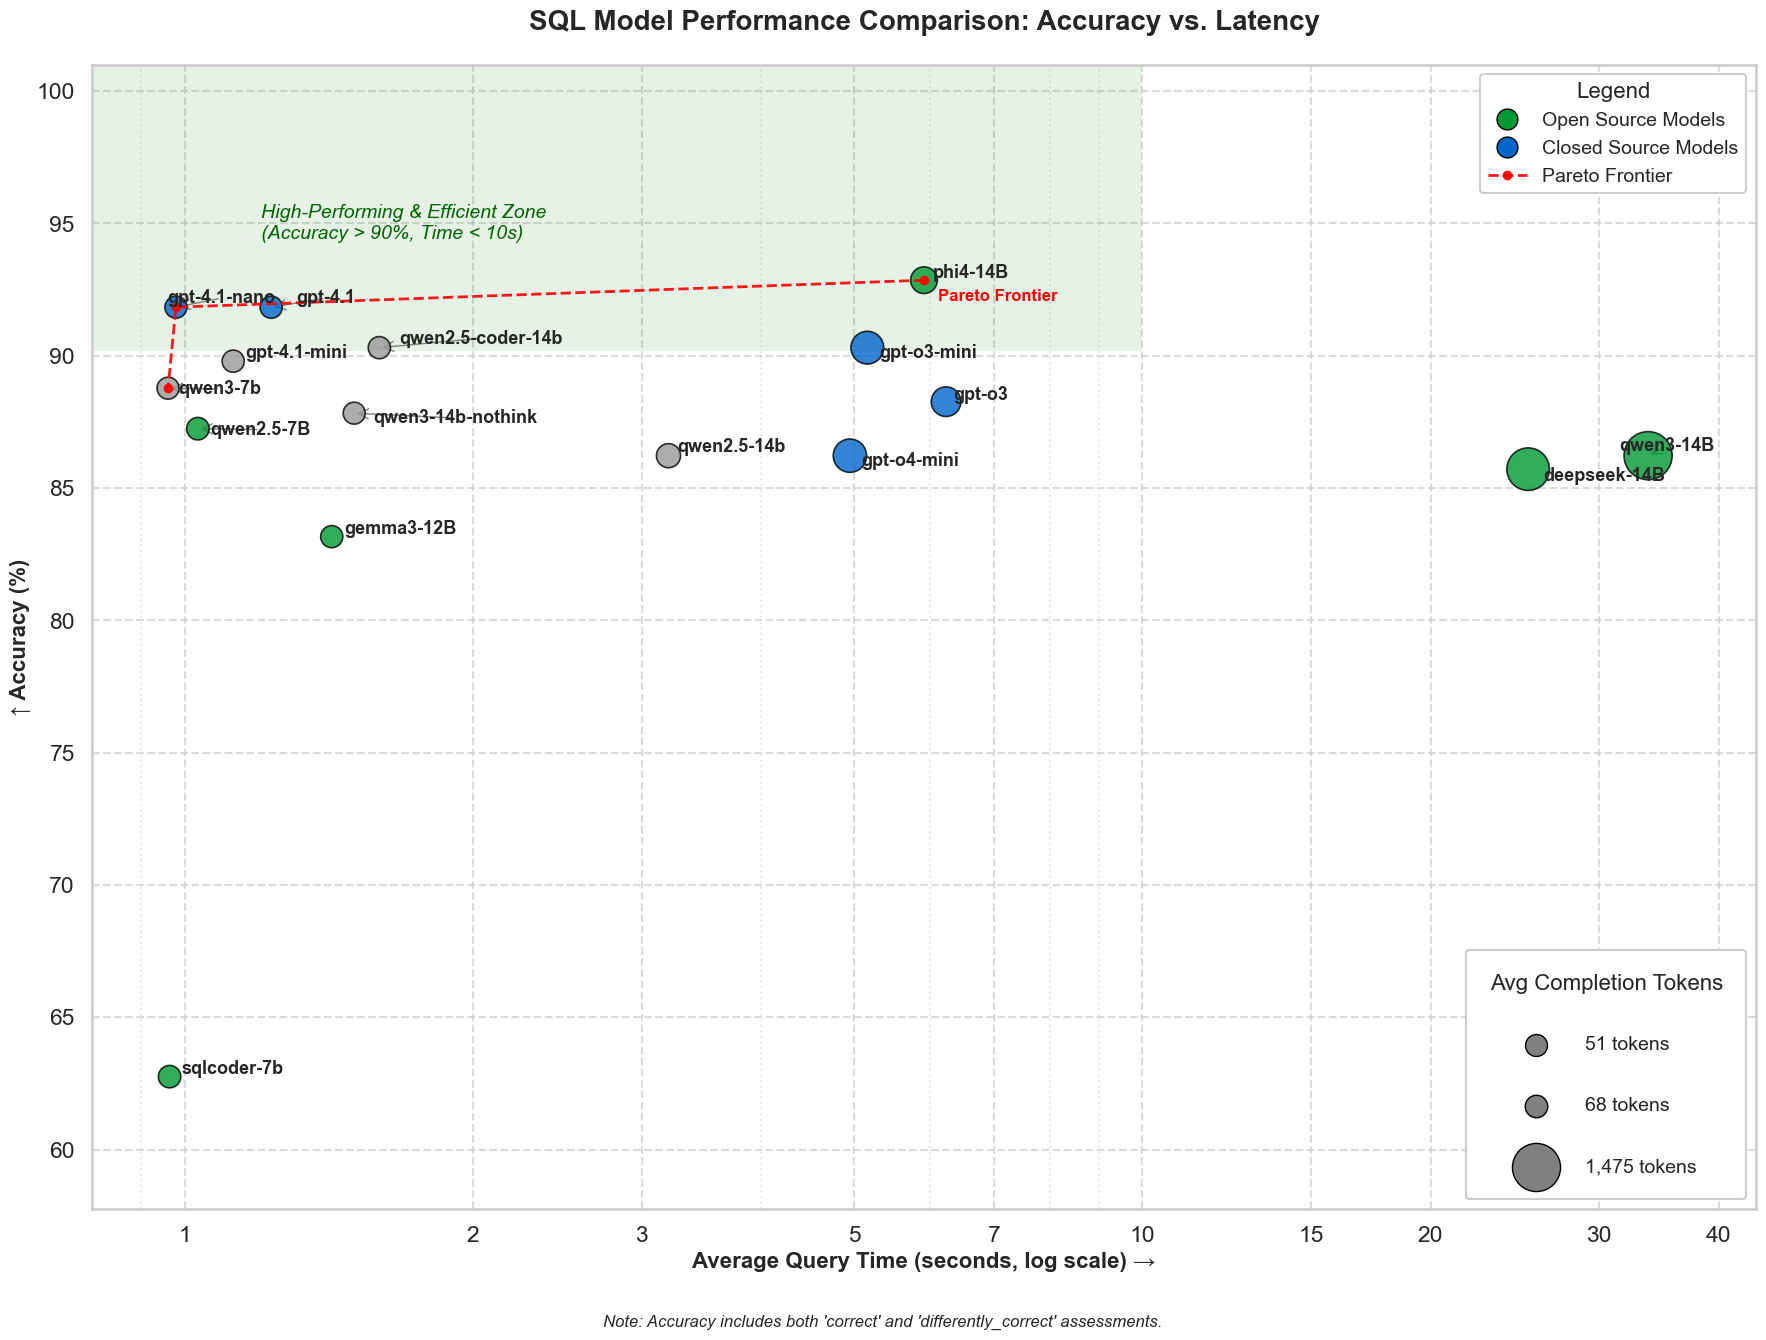

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Import ticker for custom log scale
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
from matplotlib.lines import Line2D
from adjustText import adjust_text

# Set style for a cleaner look
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ------------------------------------------------------------
# 1) Load and process all model data (No changes here)
# ------------------------------------------------------------
def load_model_data(file_path):
    """Load and process a single model's data file"""
    model_name = os.path.basename(file_path).replace('.jsonl', '')
    df = pd.read_json(file_path, lines=True)
    if 'enhanced_judgment.overall_assessment' not in df.columns:
        df['enhanced_judgment.overall_assessment'] = df['enhanced_judgment'].apply(
            lambda x: x.get('overall_assessment', 'incorrect') if isinstance(x, dict) else 'incorrect'
        )
    correct_count = sum(df['enhanced_judgment.overall_assessment'].isin(['correct', 'differently_correct']))
    accuracy = (correct_count / len(df)) * 100
    avg_time = df['latency_sec'].mean()
    avg_tokens = df['tokens_completion'].mean() if 'tokens_completion' in df.columns else 0
    return {
        'model': model_name,
        'accuracy': accuracy,
        'avg_time': avg_time,
        'avg_tokens': avg_tokens,
        'total_examples': len(df)
    }

file_paths = glob.glob('better_benchmarks/*.jsonl')
model_data = [load_model_data(file_path) for file_path in file_paths]
acc_df = pd.DataFrame(model_data)

# ------------------------------------------------------------
# 2) Define model naming and categories (No changes here)
# ------------------------------------------------------------
model_name_map = {
    'deepseek-r1-14b': 'deepseek-14B', 'gemma3-12b': 'gemma3-12B',
    'gpt-4.1-nano': 'gpt-4.1-nano', 'gpt-4.1': 'gpt-4.1',
    'o3-mini': 'gpt-o3-mini', 'o3': 'gpt-o3', 'o4-mini': 'gpt-o4-mini',
    'qwen3-14b': 'qwen3-14B', 'sqlcoder-latest': 'sqlcoder-7b',
    'qwen2.5-latest': 'qwen2.5-7B', 'phi4-14b': 'phi4-14B'
}
model_categories = {
    'Open Source Models': ['deepseek-r1-14b', 'gemma3-12b', 'qwen3-14b', 'sqlcoder-latest', 'qwen2.5-latest', 'phi4-14b'],
    'Closed Source Models': ['o3-mini', 'o3', 'o4-mini', 'gpt-4.1', 'gpt-4.1-nano']
}
category_colors = {'Open Source Models': '#009933', 'Closed Source Models': '#0066CC'}
acc_df['category'] = 'Unknown'
for model in acc_df['model']:
    for category, models in model_categories.items():
        if model in models:
            acc_df.loc[acc_df['model'] == model, 'category'] = category
acc_df['color'] = acc_df['category'].map(category_colors).fillna('#999999')
acc_df['model_display'] = acc_df['model'].map(model_name_map).fillna(acc_df['model'])

# ------------------------------------------------------------
# 3) Scale token counts for bubble sizes (No changes here)
# ------------------------------------------------------------
S_MIN, S_MAX = 250, 1200
def scale_sizes(series, s_min=S_MIN, s_max=S_MAX):
    if series.max() == series.min(): return np.full_like(series, (s_min + s_max) / 2)
    return np.interp(series, (series.min(), series.max()), (s_min, s_max))
sizes = scale_sizes(acc_df["avg_tokens"])

# ------------------------------------------------------------
# 4) --- IMPROVED: Create the plot and set up log scale ---
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_xscale('log') # Set x-axis to log scale
ax.grid(which='major', linestyle='--', alpha=0.7, zorder=0)
ax.grid(which='minor', linestyle=':', alpha=0.4, zorder=0)

# --- IMPROVED: Add a shaded region using data coordinates ---
ymin_zone = (90 - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0])
ax.axvspan(0, 10, ymin=0.75, facecolor='green', alpha=0.1, zorder=1)
ax.text(1.2, 95, 'High-Performing & Efficient Zone\n(Accuracy > 90%, Time < 10s)',
        fontsize=14, color='darkgreen', style='italic', va='center')

# Create the scatter plot
scatter = ax.scatter(
    acc_df["avg_time"], acc_df["accuracy"], s=sizes, c=acc_df["color"],
    alpha=0.8, edgecolors='black', linewidth=1.2, zorder=10
)

# ------------------------------------------------------------
# 5) --- IMPROVED: Identify and plot the Pareto Frontier ---
# ------------------------------------------------------------
pareto_df = acc_df.sort_values(['accuracy', 'avg_time'], ascending=[False, True])
pareto_frontier = []
min_time = float('inf')
for index, row in pareto_df.iterrows():
    if row['avg_time'] < min_time:
        pareto_frontier.append(row)
        min_time = row['avg_time']
pareto_frontier_df = pd.DataFrame(pareto_frontier)
ax.plot(
    pareto_frontier_df['avg_time'], pareto_frontier_df['accuracy'],
    color='red', linestyle='--', marker='o', markersize=6,
    linewidth=2.0, label='Pareto Frontier', zorder=15, alpha=0.9
)
ax.annotate("Pareto Frontier", xy=(pareto_frontier_df['avg_time'].iloc[0], pareto_frontier_df['accuracy'].iloc[0]),
            xytext=(10, -15), textcoords="offset points",
            fontsize=12, color='red', fontweight='bold')

# ------------------------------------------------------------
# 6) --- IMPROVED: Use adjustText with stronger settings ---
# ------------------------------------------------------------
texts = []
for i, row in acc_df.iterrows():
    texts.append(ax.text(
        row.avg_time, row.accuracy, row.model_display,
        fontsize=13, fontweight='bold', zorder=25
    ))

# Use stronger settings to force labels apart
adjust_text(texts, ax=ax,
            force_text=(0.8, 1.5),
            force_points=(0.8, 0.8),
            expand_points=(1.5, 1.5),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.0),
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=0.5, alpha=0.95))

# ------------------------------------------------------------
# 7) --- IMPROVED: Add legends, labels, and custom ticks ---
# ------------------------------------------------------------
# Model Types Legend
category_handles = [Line2D([0], [0], marker='o', color='w',
                           markerfacecolor=color, markeredgecolor='black',
                           markersize=15, label=category)
                    for category, color in category_colors.items()]
category_handles.append(ax.get_legend_handles_labels()[0][0])
type_legend = ax.legend(handles=category_handles, loc="upper right", fontsize=14,
                        frameon=True, framealpha=0.95, title="Legend", title_fontsize=16)
ax.add_artist(type_legend)

# Bubble Size Legend
token_vals = [int(acc_df["avg_tokens"].min()), int(acc_df["avg_tokens"].median()), int(acc_df["avg_tokens"].max())]
size_vals = scale_sizes(pd.Series(token_vals))
handles = [plt.scatter([], [], s=s, color="gray", edgecolor="black", linewidth=1.0) for s in size_vals]
labels = [f"{t:,} tokens" for t in token_vals]
size_legend = ax.legend(handles, labels, title="Avg Completion Tokens", loc="lower right",
                        fontsize=14, title_fontsize=16, labelspacing=2.2, borderpad=1.2,
                        handletextpad=1.5, frameon=True, framealpha=0.95)
ax.add_artist(size_legend)

# Add labels and title
ax.set_xlabel("Average Query Time (seconds, log scale) →", fontsize=16, fontweight='bold')
ax.set_ylabel("↑ Accuracy (%)", fontsize=16, fontweight='bold')
ax.set_title("SQL Model Performance Comparison: Accuracy vs. Latency", fontsize=20, fontweight='bold', pad=25)

# --- NEW: Set custom, human-readable ticks for the log scale ---
major_ticks = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40]
ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.NullFormatter()) # Hide minor tick labels

# Set axis limits
ax.set_ylim(max(55, acc_df["accuracy"].min() - 5), 101)
ax.set_xlim(left=0.8, right=acc_df["avg_time"].max() + 10)

plt.figtext(0.5, 0.01, "Note: Accuracy includes both 'correct' and 'differently_correct' assessments.",
            ha='center', fontsize=12, style='italic')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('sql_model_comparison_log_scale.png', dpi=300, bbox_inches='tight')
plt.show()

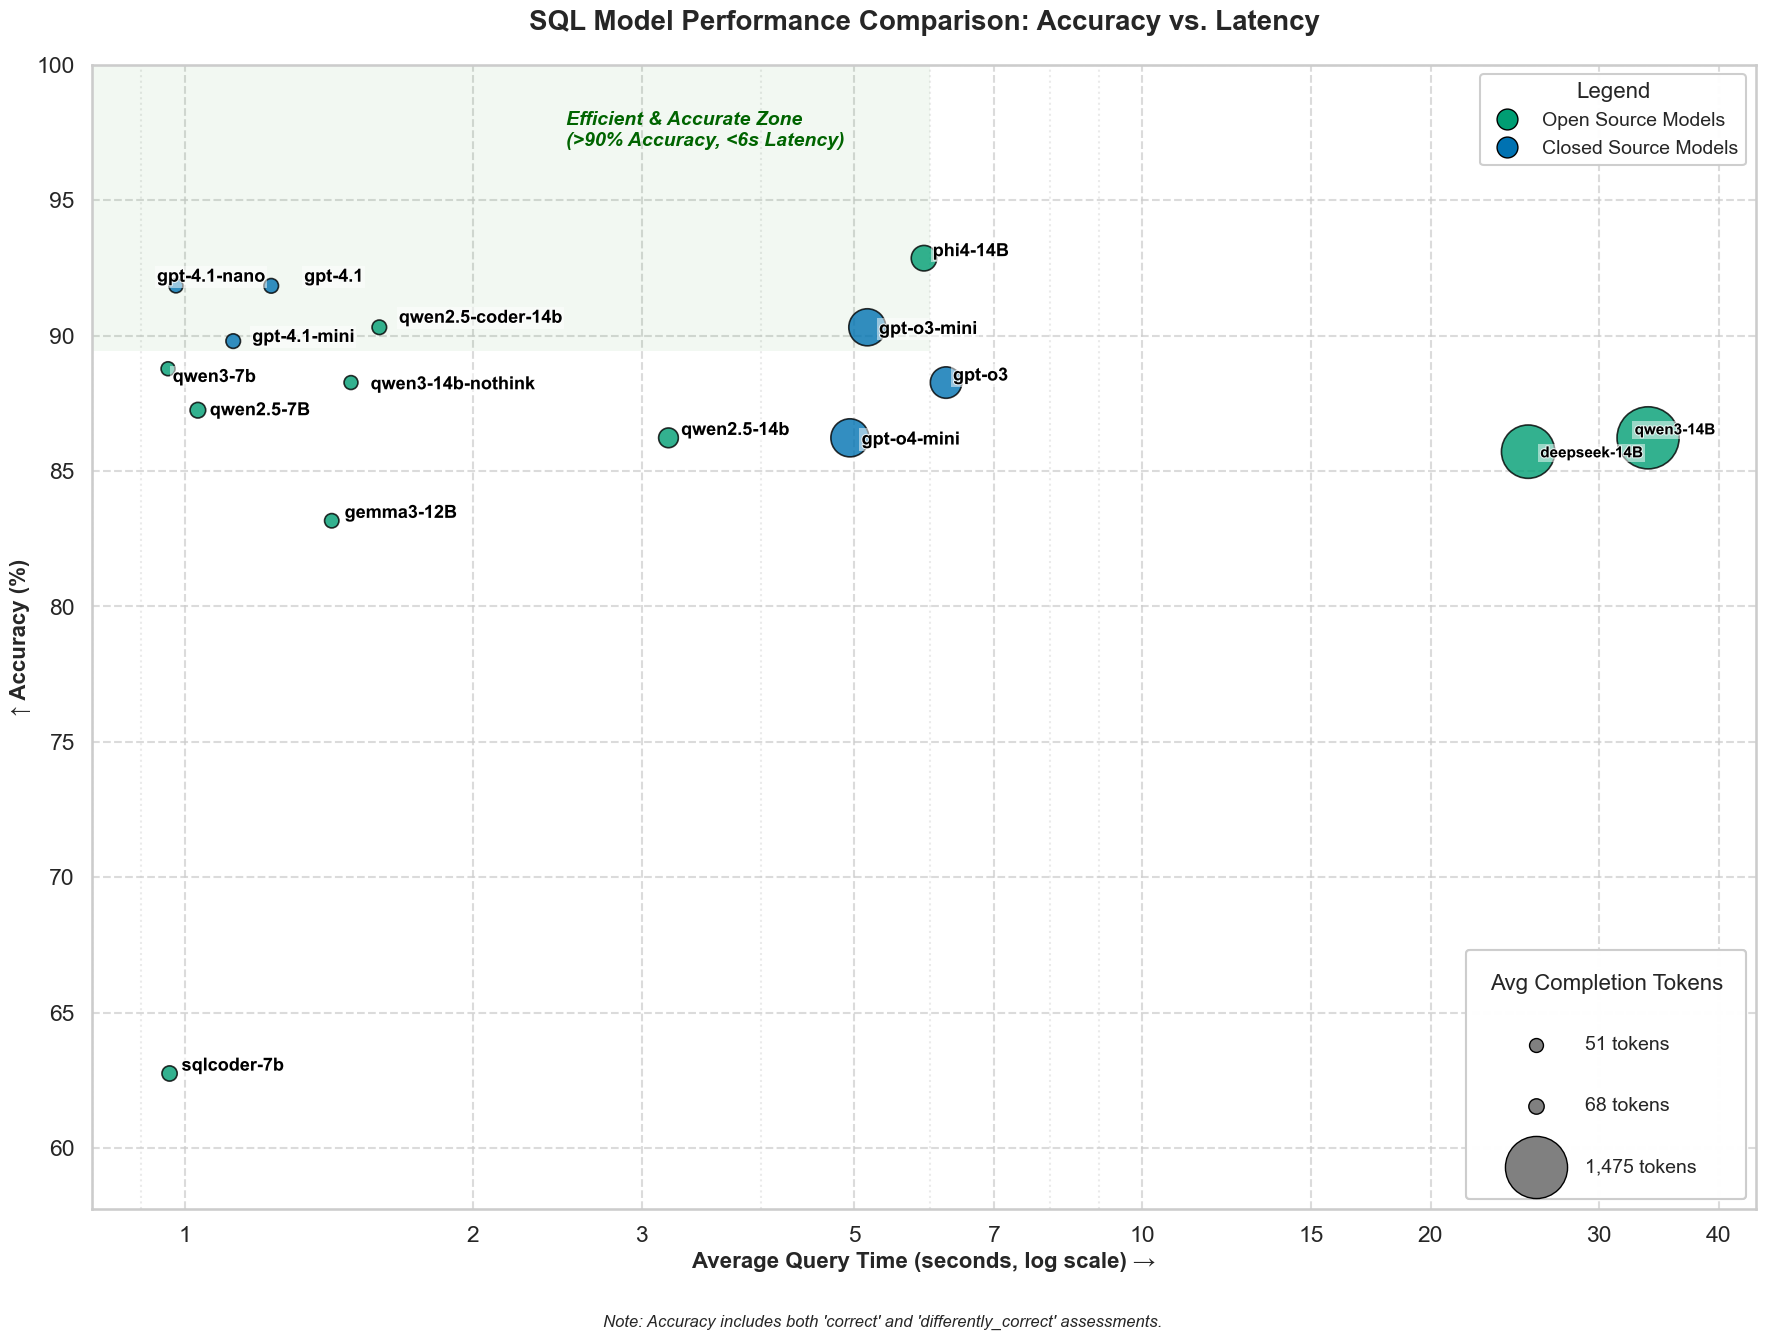

In [74]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
from matplotlib.lines import Line2D
from adjustText import adjust_text
import matplotlib.patheffects as path_effects


# Set style for a cleaner look
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# ------------------------------------------------------------
# 1) Load and process all model data (No changes)
# ------------------------------------------------------------
def load_model_data(file_path):
    model_name = os.path.basename(file_path).replace('.jsonl', '')
    df = pd.read_json(file_path, lines=True)
    if 'enhanced_judgment.overall_assessment' not in df.columns:
        df['enhanced_judgment.overall_assessment'] = df['enhanced_judgment'].apply(
            lambda x: x.get('overall_assessment', 'incorrect') if isinstance(x, dict) else 'incorrect'
        )
    correct_count = sum(df['enhanced_judgment.overall_assessment'].isin(['correct', 'differently_correct']))
    accuracy = (correct_count / len(df)) * 100
    avg_time = df['latency_sec'].mean()
    avg_tokens = df['tokens_completion'].mean() if 'tokens_completion' in df.columns else 0
    return {
        'model': model_name, 'accuracy': accuracy, 'avg_time': avg_time,
        'avg_tokens': avg_tokens, 'total_examples': len(df)
    }

file_paths = glob.glob('better_benchmarks/*.jsonl')
model_data = [load_model_data(file_path) for file_path in file_paths]
acc_df = pd.DataFrame(model_data)

# ------------------------------------------------------------
# 2) --- UPDATED: Define model naming and categories ---
# ------------------------------------------------------------
model_name_map = {
    'deepseek-r1-14b': 'deepseek-14B', 'gemma3-12b': 'gemma3-12B',
    'gpt-4.1-nano': 'gpt-4.1-nano', 'gpt-4.1': 'gpt-4.1',
    'o3-mini': 'gpt-o3-mini', 'o3': 'gpt-o3', 'o4-mini': 'gpt-o4-mini',
    'qwen3-14b': 'qwen3-14B', 'sqlcoder-latest': 'sqlcoder-7b',
    'qwen2.5-latest': 'qwen2.5-7B', 'phi4-14b': 'phi4-14B',
    'gpt-4.1-mini': 'gpt-4.1-mini',
    'qwen3-14b-nothink': 'qwen3-14b-nothink',
    'qwen3-7b': 'qwen3-7b',
    'qwen2.5-14b': 'qwen2.5-14b'
}
model_categories = {
    'Open Source Models': ['deepseek-r1-14b', 'gemma3-12b', 'qwen3-14b', 'sqlcoder-latest', 'qwen2.5-14b',
                           'qwen2.5-latest', 'phi4-14b', 'qwen2.5-coder-14b', 'qwen3-7b', 'qwen3-14b-nothink'],
    'Closed Source Models': ['o3-mini', 'o3', 'o4-mini', 'gpt-4.1', 'gpt-4.1-nano', 'gpt-4.1-mini']
}
category_colors = {
    'Open Source Models': '#009E73',   # Teal green
    'Closed Source Models': '#0072B2'  # Blue
}
acc_df['category'] = 'Unknown'
for model in acc_df['model']:
    for category, models in model_categories.items():
        if model in models:
            acc_df.loc[acc_df['model'] == model, 'category'] = category
acc_df['color'] = acc_df['category'].map(category_colors).fillna('#999999')
acc_df['model_display'] = acc_df['model'].map(model_name_map).fillna(acc_df['model'])

# ------------------------------------------------------------
# 3) Scale token counts for bubble sizes (No changes)
# ------------------------------------------------------------
S_MIN, S_MAX = 100, 2000
def scale_sizes(series, s_min=S_MIN, s_max=S_MAX):
    if series.max() == series.min(): return np.full_like(series, (s_min + s_max) / 2)
    return np.interp(series, (series.min(), series.max()), (s_min, s_max))
sizes = scale_sizes(acc_df["avg_tokens"])

# ------------------------------------------------------------
# 4) Create the plot and set up log scale (No changes)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_xscale('log')
ax.grid(which='major', linestyle='--', alpha=0.7, zorder=0)
ax.grid(which='minor', linestyle=':', alpha=0.4, zorder=0)
ax.axvspan(0, 6, ymin=0.75, facecolor='green', alpha=0.05, zorder=1)
ax.text(2.5, 97, 'Efficient & Accurate Zone\n(>90% Accuracy, <6s Latency)',
        fontsize=14, color='darkgreen', style='italic', weight='bold')
scatter = ax.scatter(
    acc_df["avg_time"], acc_df["accuracy"], s=sizes, c=acc_df["color"],
    alpha=0.8, edgecolors='black', linewidth=1.2, zorder=10
)

# ------------------------------------------------------------
# 5) Identify and plot the Pareto Frontier (No changes)
# ------------------------------------------------------------
# pareto_df = acc_df.sort_values(['accuracy', 'avg_time'], ascending=[False, True])
# pareto_frontier = []
# min_time = float('inf')
# for index, row in pareto_df.iterrows():
#     if row['avg_time'] < min_time:
#         pareto_frontier.append(row)
#         min_time = row['avg_time']
# pareto_frontier_df = pd.DataFrame(pareto_frontier)
# ax.plot(pareto_frontier_df['avg_time'], pareto_frontier_df['accuracy'],
#         color='red', linestyle='--', marker='o', markersize=6,
#         linewidth=2.5, label='Pareto Frontier', zorder=15)

# ------------------------------------------------------------
# 6) --- FINAL IMPROVEMENT: Use highly aggressive adjustText settings ---
# ------------------------------------------------------------
texts = []
for i, row in acc_df.iterrows():
    text = ax.text(
        row.avg_time, row.accuracy, row.model_display,
        fontsize=11 if row['avg_time'] > 10 else 13,
        fontweight='bold', zorder=25,
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, pad=1.5)
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='white', alpha=0.8),
        path_effects.Normal()
    ])
    texts.append(text)

# Use much stronger force settings to guarantee no overlap
adjust_text(texts, ax=ax,
            force_text=(10.0, 10.0),      # Significantly increased force to push text apart
            force_points=(10.0, 10.0),    # Force to push text away from points
            expand_text=(5, 5),     # Padding around text boxes
            expand_points=(10.5, 10.5),   # Padding around data points
            lim=1000,                   # More iterations to find a solution
) # Add space at arrow ends

# ------------------------------------------------------------
# 7) Add legends, labels, and custom ticks (No changes)
# ------------------------------------------------------------
category_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markeredgecolor='black', markersize=15, label=category) for category, color in category_colors.items()]
# category_handles.append(ax.get_legend_handles_labels()[0][0])
type_legend = ax.legend(handles=category_handles, loc="upper right", fontsize=14, frameon=True, framealpha=0.95, title="Legend", title_fontsize=16)
ax.add_artist(type_legend)

token_vals = [int(acc_df["avg_tokens"].min()), int(acc_df["avg_tokens"].median()), int(acc_df["avg_tokens"].max())]
size_vals = scale_sizes(pd.Series(token_vals))
handles = [plt.scatter([], [], s=s, color="gray", edgecolor="black", linewidth=1.0) for s in size_vals]
labels = [f"{t:,} tokens" for t in token_vals]
size_legend = ax.legend(handles, labels, title="Avg Completion Tokens", loc="lower right", fontsize=14, title_fontsize=16, labelspacing=2.2, borderpad=1.2, handletextpad=1.5, frameon=True, framealpha=0.95)
ax.add_artist(size_legend)

ax.set_xlabel("Average Query Time (seconds, log scale) →", fontsize=16, fontweight='bold')
ax.set_ylabel("↑ Accuracy (%)", fontsize=16, fontweight='bold')
ax.set_title("SQL Model Performance Comparison: Accuracy vs. Latency", fontsize=20, fontweight='bold', pad=25)

major_ticks = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40]
ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.NullFormatter())
 
ax.set_ylim(max(55, acc_df["accuracy"].min() - 5), 100)
ax.set_xlim(left=0.8, right=acc_df["avg_time"].max() + 10)

plt.figtext(0.5, 0.01, "Note: Accuracy includes both 'correct' and 'differently_correct' assessments.", ha='center', fontsize=12, style='italic')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('sql_model_comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1400x1000 with 0 Axes>

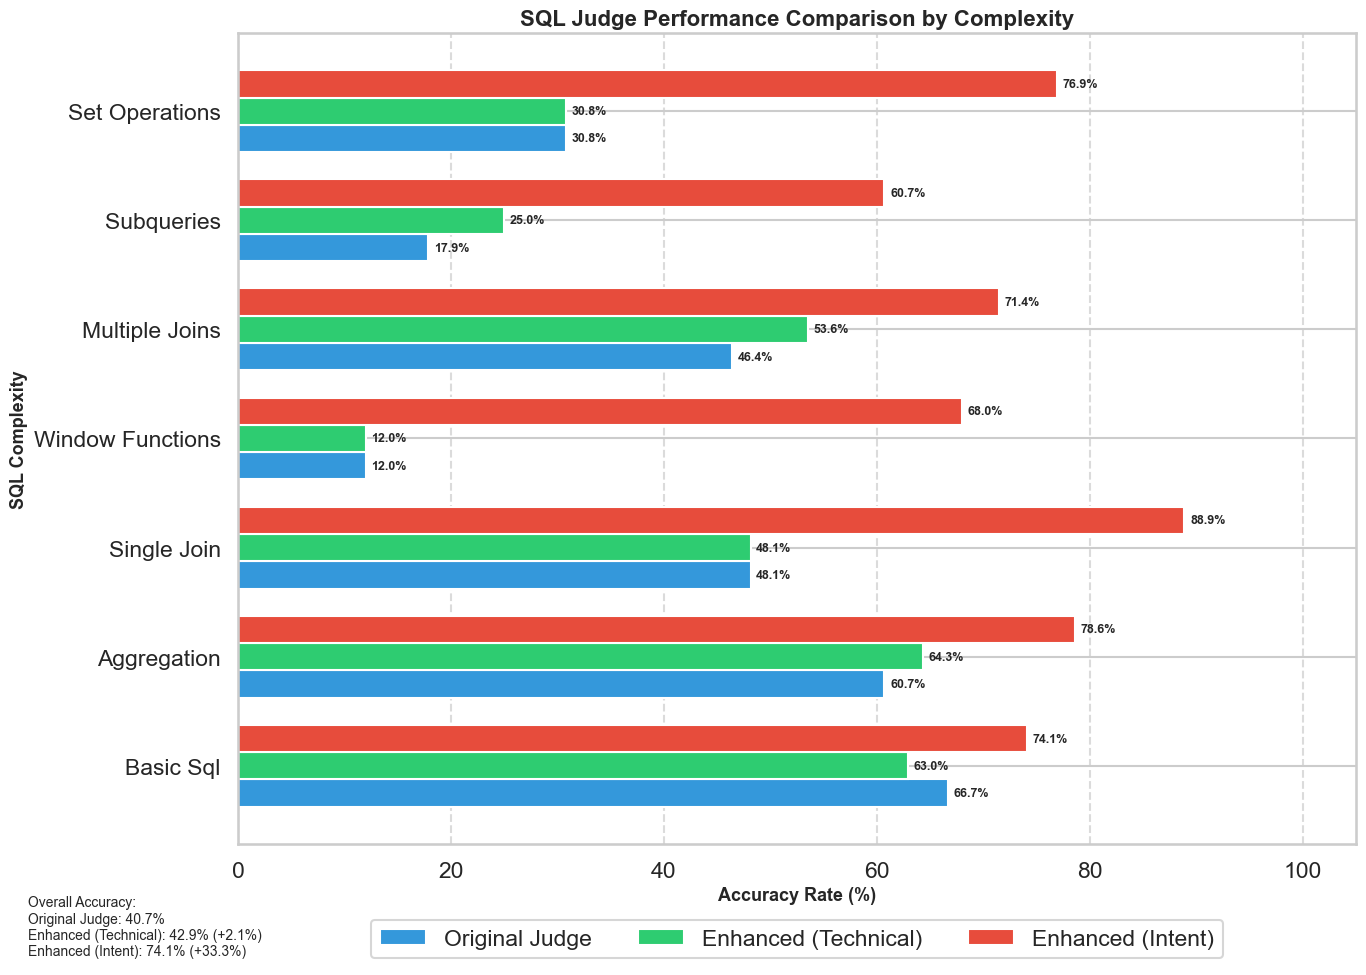

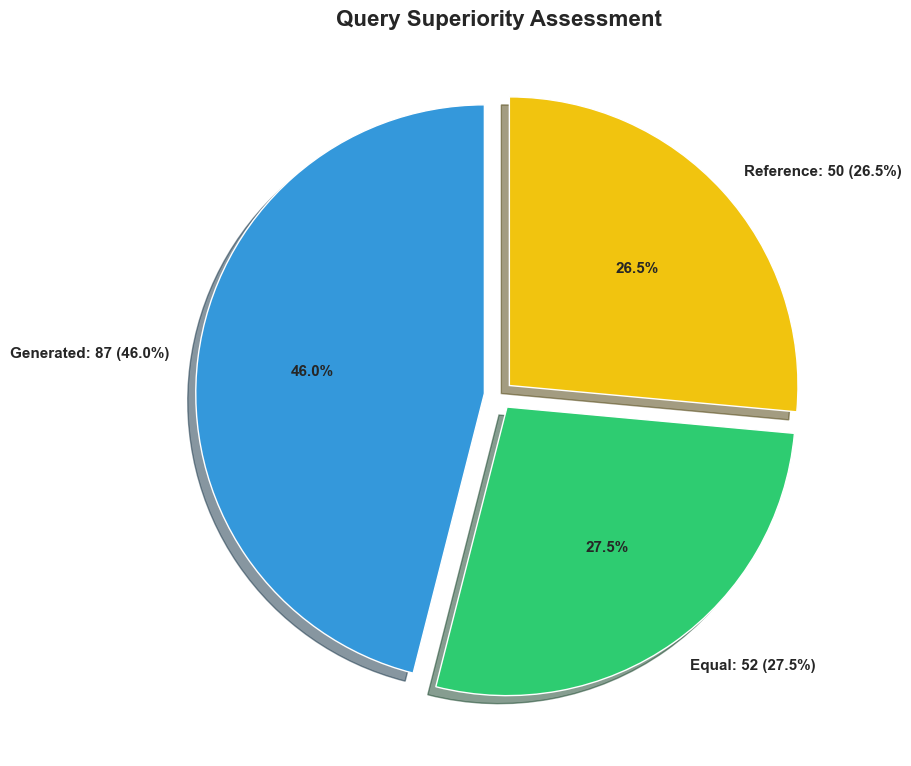

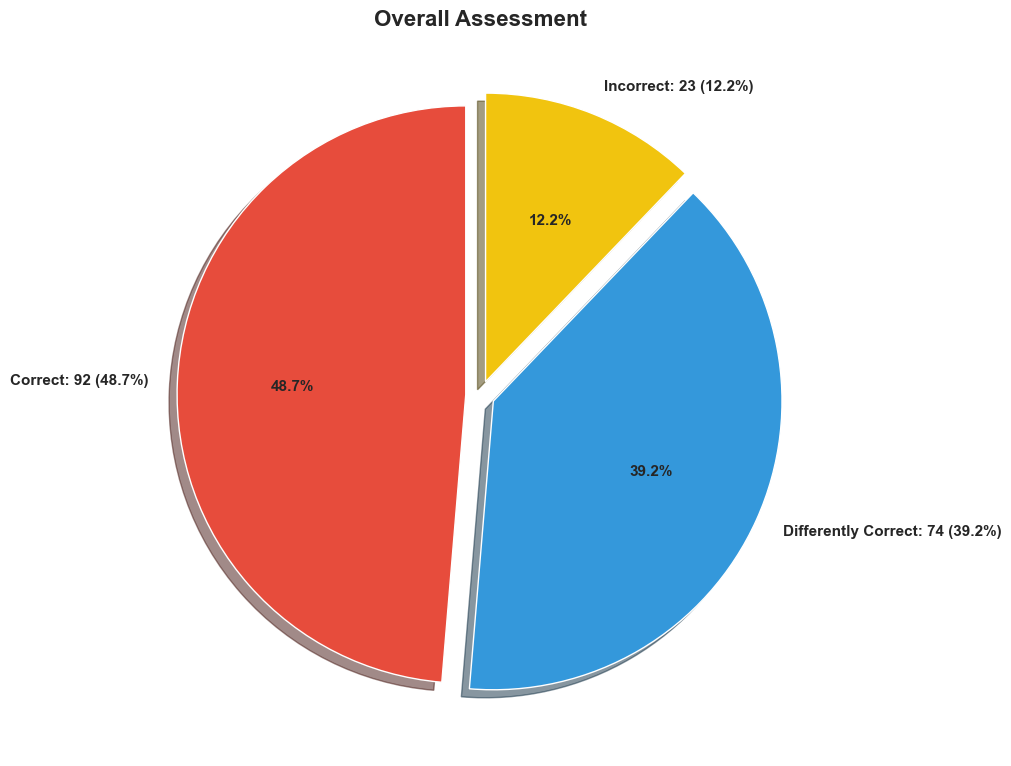

In [48]:
df = pd.read_json("better_benchmarks/qwen3-14b-nothink.jsonl", lines=True)

visualize_judge_comparison(df)

<Figure size 1400x1000 with 0 Axes>

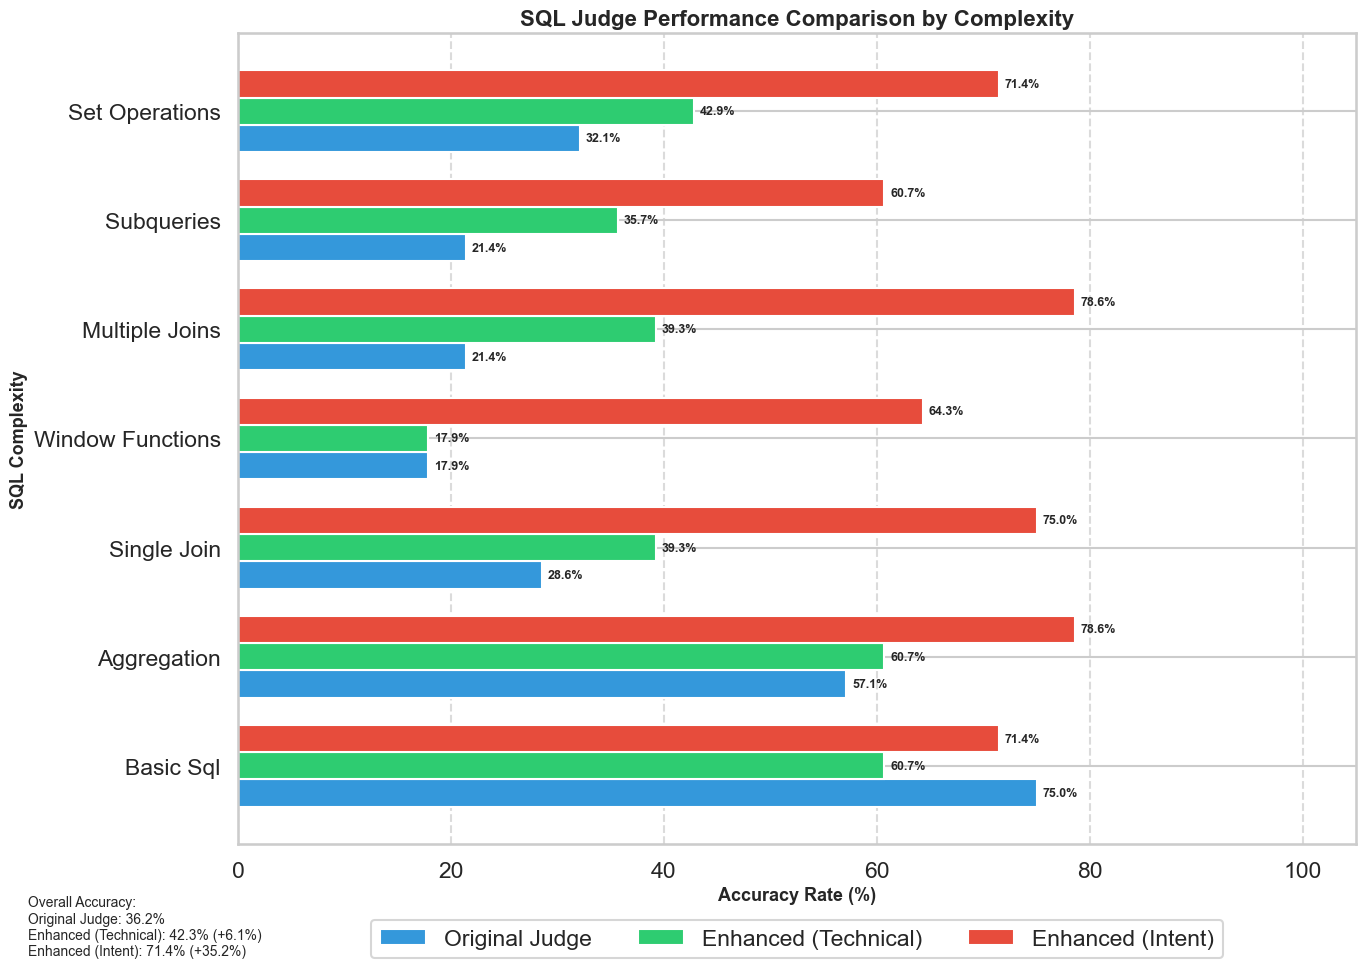

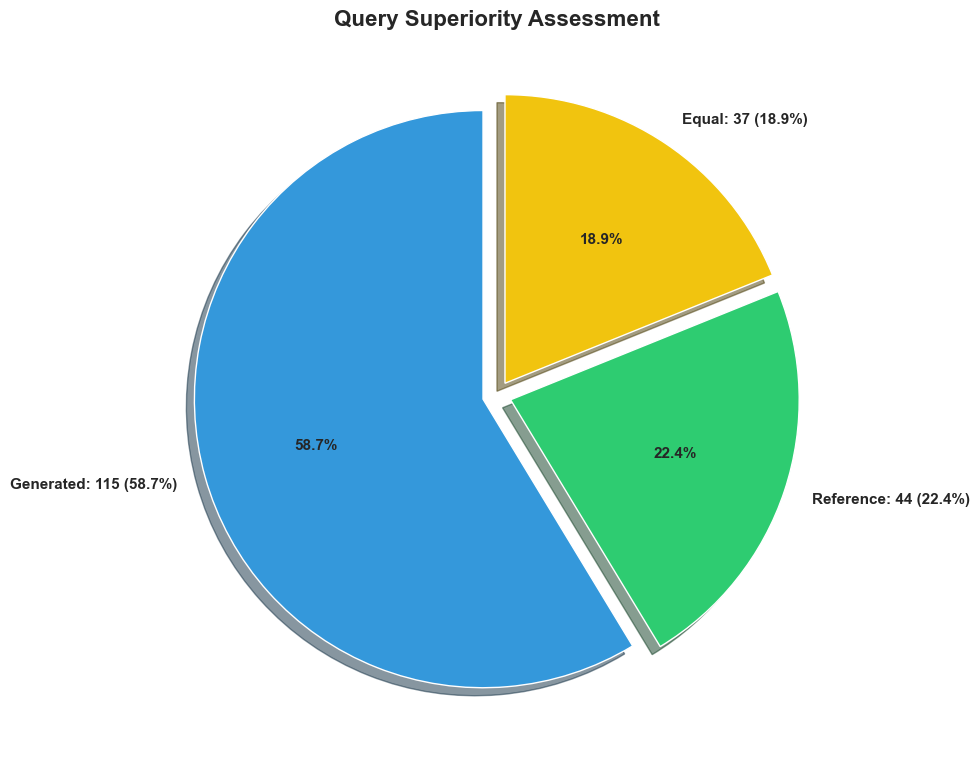

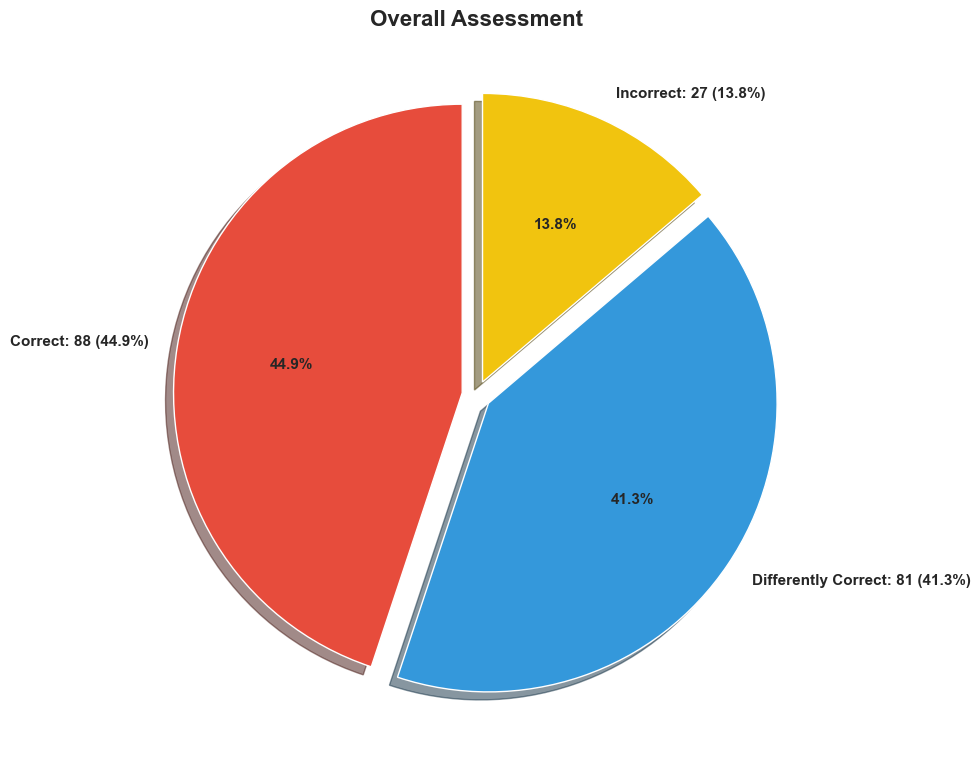

In [49]:
df = pd.read_json("better_benchmarks/qwen3-14b.jsonl", lines=True)

visualize_judge_comparison(df)

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np
from adjustText import adjust_text
import matplotlib.patheffects as path_effects

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Define complexity classes in order
_COMPLEXITY_CLASSES = [
    "basic SQL",
    "aggregation",
    "single join",
    "window functions",
    "multiple_joins",
    "subqueries",
    "set operations",
]

# Define model name mapping and categories
model_name_map = {
    'deepseek-r1-14b': 'deepseek-14B', 'gemma3-12b': 'gemma3-12B',
    'gpt-4.1-nano': 'gpt-4.1-nano', 'gpt-4.1': 'gpt-4.1',
    'o3-mini': 'gpt-o3-mini', 'o3': 'gpt-o3', 'o4-mini': 'gpt-o4-mini',
    'qwen3-14b': 'qwen3-14B', 'sqlcoder-latest': 'sqlcoder-7b',
    'qwen2.5-latest': 'qwen2.5-7B', 'phi4-14b': 'phi4-14B',
    'qwen2.5-coder-14b': 'qwen2.5-coder-14b'
}

model_categories = {
    'Open Source Models': ['deepseek-r1-14b', 'gemma3-12b', 'qwen3-14b', 'sqlcoder-latest', 'qwen2.5-latest', 'phi4-14b', 'qwen2.5-coder-14b'],
    'Closed Source Models': ['o3-mini', 'o3', 'o4-mini', 'gpt-4.1', 'gpt-4.1-nano']
}
category_colors = {
    'Open Source Models': '#009E73',
    'Closed Source Models': '#0072B2'
}

# Load data from files
def load_tokens_by_complexity(file_path):
    model_name = os.path.basename(file_path).replace('.jsonl', '')
    try:
        df = pd.read_json(file_path, lines=True)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return pd.DataFrame()

    if 'metadata' in df.columns:
        df['complexity'] = df['metadata'].apply(lambda x: x.get('complexity') if isinstance(x, dict) else None)

    if 'complexity' not in df.columns or 'tokens_completion' not in df.columns:
        return pd.DataFrame()

    df['model'] = model_name
    return df[['model', 'complexity', 'tokens_completion']].dropna()

# Load all files
file_paths = glob.glob('better_benchmarks/*.jsonl')
df_list = [load_tokens_by_complexity(path) for path in file_paths]
combined_df = pd.concat(df_list, ignore_index=True)

# Rename and categorize models
combined_df['model_display'] = combined_df['model'].map(model_name_map).fillna(combined_df['model'])

def get_category(model):
    for category, models in model_categories.items():
        if model in models:
            return category
    return 'Unknown'

combined_df['category'] = combined_df['model'].apply(get_category)
combined_df['color'] = combined_df['category'].map(category_colors).fillna('#999999')

# Ensure complexity order
combined_df['complexity'] = pd.Categorical(combined_df['complexity'], categories=_COMPLEXITY_CLASSES, ordered=True)

# Compute mean token length
agg_df = combined_df.groupby(['model_display', 'complexity', 'color'], as_index=False).agg({
    'tokens_completion': 'mean'
})
agg_df.rename(columns={'tokens_completion': 'avg_tokens'}, inplace=True)

# --------------------------------------------
# Plot
# --------------------------------------------
plt.figure(figsize=(20, 10))
sns.barplot(
    data=agg_df,
    x='complexity', y='avg_tokens',
    hue='model_display',
    palette=dict(zip(combined_df['model_display'], combined_df['color'])),
    edgecolor='black'
)

plt.title("Average Output Token Length by Query Complexity", fontsize=20, fontweight='bold', pad=15)
plt.xlabel("Query Complexity", fontsize=16)
plt.ylabel("Average Completion Tokens", fontsize=16)
plt.xticks(rotation=30, ha='right')
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig("tokens_by_complexity.png", dpi=300)
plt.show()


KeyError: 'model'

Found 16 JSONL files
Successfully processed 16 files
Combined DataFrame shape: (3136, 3), columns: ['model', 'sql_complexity', 'tokens_completion']
Unique models in data: ['deepseek-14B' 'gemma3-12B' 'gpt-4.1' 'gpt-4.1-mini' 'gpt-4.1-nano'
 'gpt-o3' 'gpt-o3-mini' 'gpt-o4-mini' 'phi4-14B' 'qwen2.5-14B'
 'qwen2.5-7B' 'qwen2.5-coder-14b' 'qwen3-14B' 'qwen3-14B-nothink'
 'qwen3-7B' 'sqlcoder-7b']


/var/folders/4y/d8j9plg52_j8825m3vcslkgw0000gn/T/ipykernel_6993/2134687918.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = combined_df.groupby(['model_display', 'sql_complexity']).agg({


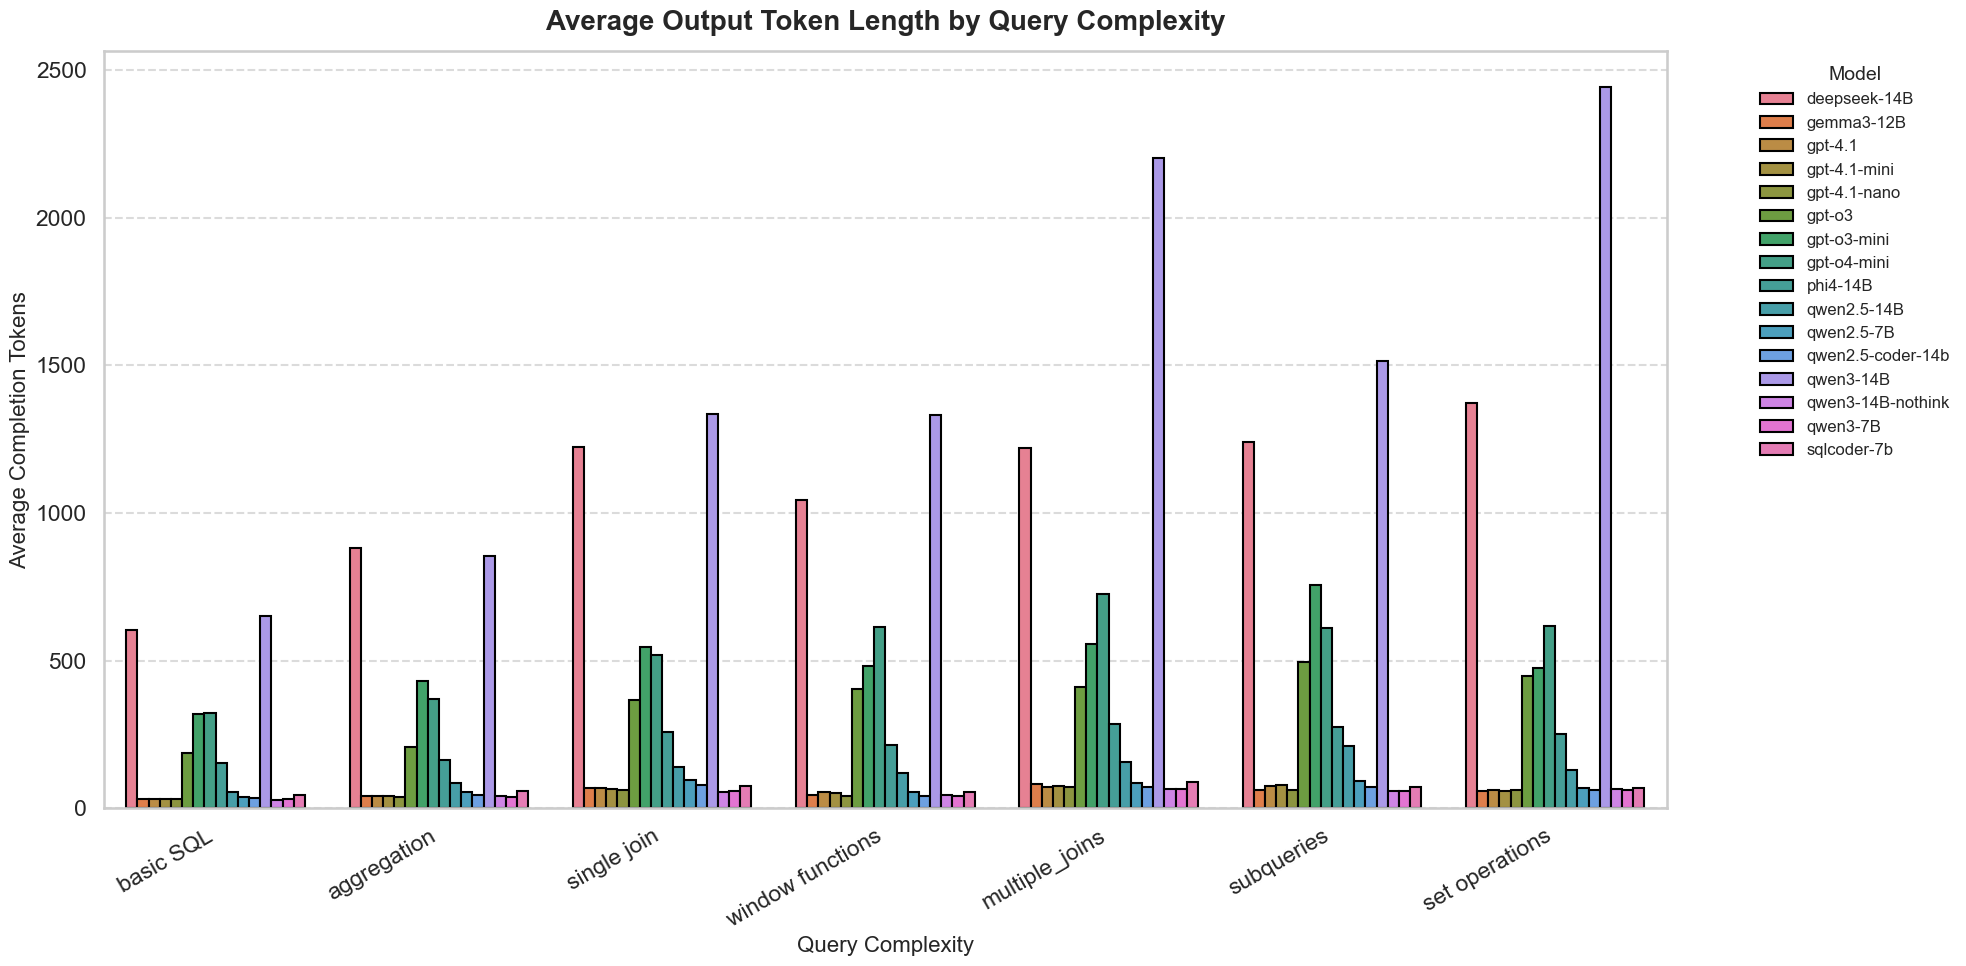

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Define complexity classes in order
_COMPLEXITY_CLASSES = [
    "basic SQL",
    "aggregation",
    "single join",
    "window functions",
    "multiple_joins",
    "subqueries",
    "set operations",
]

# Define model name mapping - updated with missing models
model_name_map = {
    'deepseek-r1-14b': 'deepseek-14B', 
    'gemma3-12b': 'gemma3-12B',
    'gpt-4.1-nano': 'gpt-4.1-nano', 
    'gpt-4.1': 'gpt-4.1',
    'gpt-4.1-mini': 'gpt-4.1-mini',  # Added
    'o3-mini': 'gpt-o3-mini', 
    'o3': 'gpt-o3', 
    'o4-mini': 'gpt-o4-mini',
    'qwen3-14b': 'qwen3-14B', 
    'qwen3-14b-nothink': 'qwen3-14B-nothink',  # Added
    'qwen3-7b': 'qwen3-7B',  # Added
    'sqlcoder-latest': 'sqlcoder-7b',
    'qwen2.5-latest': 'qwen2.5-7B', 
    'qwen2.5-14b': 'qwen2.5-14B',  # Added
    'phi4-14b': 'phi4-14B',
    'qwen2.5-coder-14b': 'qwen2.5-coder-14b'
}

# Load data from files
def load_tokens_by_complexity(file_path):
    model_name = os.path.basename(file_path).replace('.jsonl', '')
    try:
        df = pd.read_json(file_path, lines=True)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return pd.DataFrame()

    if 'metadata' in df.columns:
        df['sql_complexity'] = df['metadata'].apply(lambda x: x.get('sql_complexity') if isinstance(x, dict) else None)

    # Check required columns
    required_cols = ['sql_complexity', 'tokens_completion']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns in {file_path}: {missing_cols}")
        return pd.DataFrame()

    # Add model column explicitly
    df['model'] = model_name
    
    result = df[['model', 'sql_complexity', 'tokens_completion']].dropna()
    return result

# Load all files
file_paths = glob.glob('better_benchmarks/*.jsonl')
print(f"Found {len(file_paths)} JSONL files")

df_list = []
for path in file_paths:
    df = load_tokens_by_complexity(path)
    if not df.empty:
        df_list.append(df)

if not df_list:
    print("No valid data found in any files. Check file paths and content.")
else:
    print(f"Successfully processed {len(df_list)} files")

# Check if we have any data before concatenating
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}, columns: {combined_df.columns.tolist()}")

    # Rename models for better display
    combined_df['model_display'] = combined_df['model'].map(model_name_map).fillna(combined_df['model'])
    
    # Ensure complexity order
    combined_df['sql_complexity'] = pd.Categorical(combined_df['sql_complexity'], categories=_COMPLEXITY_CLASSES, ordered=True)

    # Calculate mean token length for each model and complexity
    agg_df = combined_df.groupby(['model_display', 'sql_complexity']).agg({
        'tokens_completion': 'mean'
    }).reset_index()
    
    agg_df.rename(columns={'tokens_completion': 'avg_tokens'}, inplace=True)

    # Get unique models for color assignment
    unique_models = agg_df['model_display'].unique()
    print(f"Unique models in data: {unique_models}")
    
    # Create color palette with enough colors for all models
    # Use a combination of colorblind-friendly palettes
    num_models = len(unique_models)
    color_palette = sns.color_palette("husl", n_colors=num_models)
    
    # --------------------------------------------
    # Plot
    # --------------------------------------------
    plt.figure(figsize=(20, 10))
    
    # Use Seaborn's barplot with generated palette
    ax = sns.barplot(
        data=agg_df,
        x='sql_complexity', 
        y='avg_tokens',
        hue='model_display',
        palette=sns.color_palette("husl", n_colors=len(unique_models)),
        edgecolor='black'
    )

    plt.title("Average Output Token Length by Query Complexity", fontsize=20, fontweight='bold', pad=15)
    plt.xlabel("Query Complexity", fontsize=16)
    plt.ylabel("Average Completion Tokens", fontsize=16)
    plt.xticks(rotation=30, ha='right')
    
    # Move legend outside of plot for better visibility
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("tokens_by_complexity.png", dpi=300)
    plt.show()
else:
    print("No data to plot. Check your data files.")

Found 16 JSONL files
Combined DataFrame shape: (3136, 3)


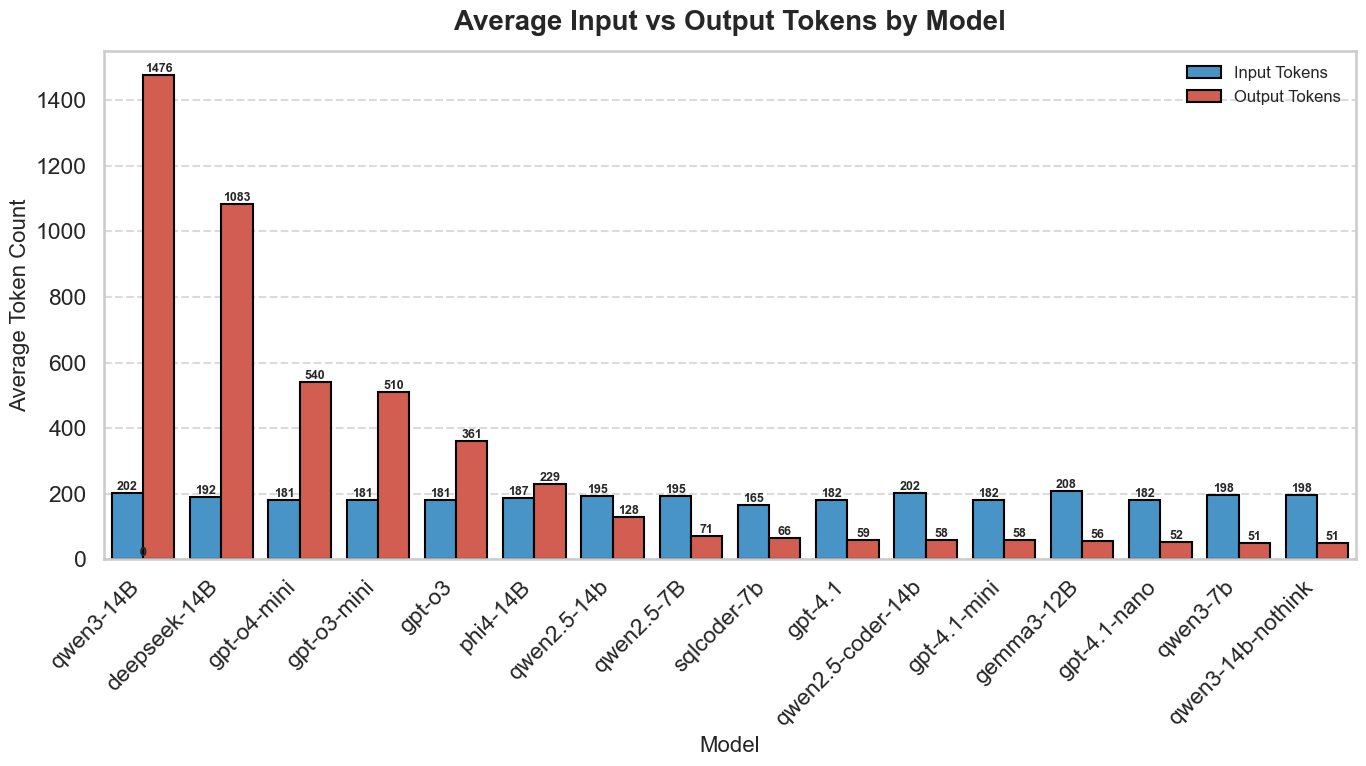

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Define model name mapping for better display
model_name_map = {
    'deepseek-r1-14b': 'deepseek-14B', 'gemma3-12b': 'gemma3-12B',
    'gpt-4.1-nano': 'gpt-4.1-nano', 'gpt-4.1': 'gpt-4.1',
    'o3-mini': 'gpt-o3-mini', 'o3': 'gpt-o3', 'o4-mini': 'gpt-o4-mini',
    'qwen3-14b': 'qwen3-14B', 'sqlcoder-latest': 'sqlcoder-7b',
    'qwen2.5-latest': 'qwen2.5-7B', 'phi4-14b': 'phi4-14B',
    'qwen2.5-coder-14b': 'qwen2.5-coder-14b'
}

# Load data from files
def load_token_data(file_path):
    model_name = os.path.basename(file_path).replace('.jsonl', '')
    try:
        df = pd.read_json(file_path, lines=True)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return pd.DataFrame()

    # Check if required columns exist
    if 'tokens_completion' not in df.columns or 'tokens_prompt' not in df.columns:
        # Try to extract from other columns if available
        if 'tokens' in df.columns:
            # Some datasets might have a tokens column with a dict structure
            try:
                df['tokens_completion'] = df['tokens'].apply(lambda x: x.get('completion', 0) if isinstance(x, dict) else 0)
                df['tokens_prompt'] = df['tokens'].apply(lambda x: x.get('prompt', 0) if isinstance(x, dict) else 0)
            except:
                print(f"Could not extract token counts from {file_path}")
                return pd.DataFrame()
        else:
            print(f"Missing required columns in {file_path}")
            return pd.DataFrame()

    # Add model column explicitly
    df['model'] = model_name
    
    return df[['model', 'tokens_prompt', 'tokens_completion']].dropna()

# Load all files
file_paths = glob.glob('better_benchmarks/*.jsonl')
print(f"Found {len(file_paths)} JSONL files")

df_list = []
for path in file_paths:
    df = load_token_data(path)
    if not df.empty:
        df_list.append(df)

if not df_list:
    print("No valid data found in any files. Check file paths and content.")
else:
    combined_df = pd.concat(df_list, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")

    # Rename models for better display
    combined_df['model_display'] = combined_df['model'].map(model_name_map).fillna(combined_df['model'])
    
    # Calculate mean tokens for each model
    agg_df = combined_df.groupby('model_display').agg({
        'tokens_prompt': 'mean',
        'tokens_completion': 'mean'
    }).reset_index()
    
    # Sort by completion tokens for better visualization
    agg_df = agg_df.sort_values('tokens_completion', ascending=False)
    
    # Reshape data for plotting
    plot_df = pd.melt(agg_df, 
                      id_vars=['model_display'],
                      value_vars=['tokens_prompt', 'tokens_completion'],
                      var_name='token_type',
                      value_name='avg_tokens')
    
    # Map token types to better labels
    plot_df['token_type'] = plot_df['token_type'].map({
        'tokens_prompt': 'Input Tokens',
        'tokens_completion': 'Output Tokens'
    })
    
    # Create plot
    plt.figure(figsize=(14, 8))
    
    # Use Seaborn's barplot
    ax = sns.barplot(
        data=plot_df,
        x='model_display', 
        y='avg_tokens',
        hue='token_type',
        palette=['#3498db', '#e74c3c'],  # Blue for input, Red for output
        edgecolor='black'
    )
    
    # Add value labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'bottom',
                    fontsize=9, fontweight='bold')
    
    # Formatting
    plt.title("Average Input vs Output Tokens by Model", fontsize=20, fontweight='bold', pad=15)
    plt.xlabel("Model", fontsize=16)
    plt.ylabel("Average Token Count", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=None, fontsize=12)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("input_output_tokens_by_model.png", dpi=300)
    plt.show()